In [1]:
import pandas as pd
import random
import datetime
import numpy as np
from itertools import repeat
import pickle
import math
import time
import gurobipy as gp
from gurobipy import *

import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
%matplotlib nbagg
import random
from collections import defaultdict

In [2]:
def create_dataframe(excel_data_path):
    """
    Takes in order data in excel format, returns order and equipments in pandas dataframes

    """
    xls = pd.ExcelFile(excel_data_path)
    items = pd.read_excel(xls, 'items')
    bins = pd.read_excel(xls, 'bins')

    return items, bins

def sort_items(items, *columns):
    """
    :param items: items dataframe
    :param columns: columns that will be sorted
    :return: sorted items dataframe
    """
    column_list = list(columns)
    bool_list = [False] * len(column_list)
    items.sort_values(by=column_list, ascending=bool_list, inplace=True)
    return items



#randomize sorting based on weight
def randomized_sort(df):
    """
    :param df: dataframe
    :return: sorted dataframe based on the condition
    """
    length = len(df) if len(df) % 2 == 0 else len(df) - 1
    for i in range(0, length, 2):
        if random.random() < 0.5:
            if (0.7 < (df.iloc[i, :].weight) / (df.iloc[i + 1, :].weight) < 1.3):
                a, b = df.iloc[i, :].copy(), df.iloc[i + 1, :].copy()
                df.iloc[i, :], df.iloc[i + 1, :] = b, a
    return df


def sort_data(items_dataframe,descending_column_list,ascending_columns_list ):
    """
    :param items: items dataframe
    :param columns: columns that will be sorted
    :return: sorted items dataframe
    """
    column_list=descending_column_list+ascending_columns_list
    bool_list=[False] * len(descending_column_list)+[True]*len(ascending_columns_list)

    items_dataframe.sort_values(by=column_list, ascending=bool_list, inplace=True)
    return items_dataframe


#randomize sorting based on weight
def randomized_weight_sort(items,column):
    """
    :param items: dataframe
    :return: sorted dataframe based on the condition
    """
    length = len(items) if len(items) % 2 == 0 else len(items) - 1
    for i in range(0, length, 2):
        if random.random() < 0.5:
            if (0.7 < (items.iloc[i, :].weight) / (items.iloc[i + 1, :].weight) < 1.3):
                a, b = items.iloc[i, :].copy(), items.iloc[i + 1, :].copy()
                items.iloc[i, :], items.iloc[i + 1, :] = b, a
    return items


def randomized_weight_sort_line_items(items_data,line_items):
    for i in line_items.keys():
        length=len(items_data[items_data.order==i]) if len(items_data[items_data.order==i]) % 2 == 0 else len(items_data[items_data.order==i]) - 1
        for ii in range(0, length, 2):
            if random.random() < 0.5:
                if (0.7 < ((items_data[items_data.order==i]).iloc[ii, :].weight) / ((items_data[items_data.order==i]).iloc[ii + 1, :].weight) < 1.3):
                    a, b = (items_data[items_data.order==i]).iloc[ii, :].copy(), (items_data[items_data.order==i]).iloc[ii + 1, :].copy()
                    (items_data[items_data.order==i]).iloc[ii, :], (items_data[items_data.order==i]).iloc[ii + 1, :] = b, a
    return items_data


def group_by_sum(items_dataframe, group_by_column, volume,weight):

    items_dataframe["sum_volume"] = items_dataframe.groupby(group_by_column)[[volume]].transform(sum)
    items_dataframe["sum_weight"] = items_dataframe.groupby(group_by_column)[[weight]].transform(sum)

    return items_dataframe


In [3]:
filepath="C:/Users/Ashrafur.Rahman/OneDrive - Blume Global/Data and Codes/Container Loading/data/3d-bin-packing/3d-bin-packing-toy-large-200-line-items-7.xlsx"

#filepath=r"C:\Users\Ashrafur.Rahman\OneDrive - Blume Global\Data and Codes\Container Loading\data\3d-bin-packing\3d-bin-packing-toy-large-200-line-items.xlsx"

items_data, bins_data=create_dataframe(filepath)


In [5]:
items_data=group_by_sum(items_data,"order","volume","weight")
items_data=sort_data(items_data,["sum_volume","sum_weight",'volume',"weight"],["order"])
items_data

,order,order_item,item,length,height,width,volume,weight,p_class,stackability,customer,priority,sum_volume,sum_weight
65,7,6,66,6,5,6,180,669,D,1,1,3,848,6619
60,7,1,61,5,5,6,150,847,C,1,3,3,848,6619
68,7,9,69,5,5,4,100,935,C,0,2,2,848,6619
67,7,8,68,3,5,5,75,486,B,0,2,1,848,6619
66,7,7,67,6,3,4,72,923,A,1,2,1,848,6619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1,3,3,3,5,4,60,769,C,1,2,3,612,8073
9,1,10,10,5,3,4,60,669,B,1,3,3,612,8073
5,1,6,6,3,5,4,60,455,B,1,1,1,612,8073
3,1,4,4,3,5,3,45,969,D,0,3,1,612,8073


In [6]:
bins_data

,bin,type,length,height,width,volume,weight
0,1,53-ft,53,9,8.5,4054.5,57000
1,2,53-ft,53,9,8.5,4054.5,57000
2,3,40-ft,40,8,8.5,2720.0,48200
3,4,40-ft,40,8,8.5,2720.0,48200
4,5,20-ft,20,8,8.5,1360.0,42000
5,6,20-ft,20,8,8.5,1360.0,42000
6,7,20-ft,20,8,8.5,1360.0,42000


In [20]:

ww=dict(zip(items_data.item,items_data.width))
ll=dict(zip(items_data.item,items_data.length))
hh=dict(zip(items_data.item,items_data.height))
weight=dict(zip(items_data.item,items_data.weight))
volume=dict(zip(items_data.item,items_data.volume))
p_class=dict(zip(items_data.item,items_data.p_class))
stack_item=dict(zip(items_data.item,items_data.stackability))
customer=dict(zip(items_data.item,items_data.customer))
priority=dict(zip(items_data.item,items_data.priority))

orders=list(items_data.order.unique())
line_items={}
for o in orders:
    line_items[o]=items_data[items_data["order"]==o].item.to_list()
line_items_volume={}
for o in line_items:
    line_items_volume[o]=sum(volume[i] for i in line_items[o])

In [21]:
items_data=randomized_weight_sort_line_items(items_data,line_items)


In [22]:
items_data

,order,order_item,item,length,height,width,volume,weight,p_class,stackability,customer,priority,sum_volume,sum_weight
65,7,6,66,6,5,6,180,669,D,1,1,3,848,6619
60,7,1,61,5,5,6,150,847,C,1,3,3,848,6619
68,7,9,69,5,5,4,100,935,C,0,2,2,848,6619
67,7,8,68,3,5,5,75,486,B,0,2,1,848,6619
66,7,7,67,6,3,4,72,923,A,1,2,1,848,6619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1,3,3,3,5,4,60,769,C,1,2,3,612,8073
9,1,10,10,5,3,4,60,669,B,1,3,3,612,8073
5,1,6,6,3,5,4,60,455,B,1,1,1,612,8073
3,1,4,4,3,5,3,45,969,D,0,3,1,612,8073


In [23]:
bins_dim=dict(zip(bins_data.bin,zip(bins_data.type,bins_data.length,bins_data.height,bins_data.width,bins_data.volume,bins_data.weight)))


#bin characteristics
L={}
W={}
H={}
volume_capacity={}
weight_capacity={}
volume_utilization={}
weight_utilization={}
#bins=[1,2,3]
bins=bins_data.bin.tolist()
zones=4

orientations=['o1','o2','o3','o4','o5','o6']

weight_capacity_zone={}
for e in bins:
    L[e]=bins_dim[e][1]
    W[e]=bins_dim[e][3]
    H[e]=bins_dim[e][2]

    volume_capacity[e]=bins_dim[e][4]
    weight_capacity[e]=bins_dim[e][5]

In [24]:
#iteration results
IP_iter={}
volume_utilization_iter={}
weight_utilization_iter={}
c_gravity_y_iter={}
dev_gravity_center_iter={}

unused_bins_iter={}
used_bins_iter={}

x_iter={}
y_iter={}
z_iter={}

l_iter={}
w_iter={}
h_iter={}

iterations=50

In [25]:
bins

[1, 2, 3, 4, 5, 6, 7]

In [26]:
line_items

{7: [66, 61, 69, 68, 67, 70, 64, 65, 62, 63],
 2: [13, 16, 14, 17, 18, 15, 12, 11, 19, 20],
 5: [50, 45, 42, 41, 48, 47, 46, 49, 43, 44],
 3: [29, 27, 23, 22, 24, 21, 30, 26, 25, 28],
 6: [59, 54, 53, 56, 57, 60, 58, 51, 55, 52],
 4: [38, 34, 35, 37, 31, 33, 40, 36, 39, 32],
 1: [2, 9, 8, 7, 5, 3, 10, 6, 4, 1]}

In [27]:
%%capture output --no-stderr

for it in range(1,iterations+1):
    orders_to_bins={}
    P_available={}
    l_available_e={}
    w_available_e={}
    sa_e={}
    under_e={}
    stack_e={}
    volume_available_e={}

    for e in bins:
        P_available[e]=[(0,0,0)]
        l_available_e[e]={(0,0,0):L[e]}
        w_available_e[e]={(0,0,0):W[e]}
        sa_e[e]={(0,0,0):L[e]*W[e]}
        under_e[e]={(0,0,0):0}
        stack_e[e]={(0,0,0):1}
        volume_available_e[e]=L[e]*W[e]*H[e]

#    I={}
 #   for o in orders:
 #       I[o]=items_data[items_data["order"]==o].item.to_list()
# for each order
    #I=items_data.item.tolist() #list of items need to be packed
    x_o={} #x coordinate of insertion point (RBL) of items in bins
    y_o={} #y coordinate of insertion point (RBL) of items in bins
    z_o={} #z coordinate of insertion point (RBL) of items in bins

    l_o={} #length of items in bins
    w_o={} #width of items in bins
    h_o={} #height of items in bins
    items_volumes={}
    for o_ in line_items:
        I=line_items[o_]
        print("\n@#$%start of line items")
        print("@#$% for o_ in orders: ", o_)
        IU=[x for x in I]
        print("I: ",I)
        print("IU: ",IU)

        items_volumes[o_]=sum(volume[i] for i in I)

        #vehicle level properties
        IP_e={} #item packed in bins

        x_e={} #x coordinate of insertion point (RBL) of items in bins
        y_e={} #y coordinate of insertion point (RBL) of items in bins
        z_e={} #z coordinate of insertion point (RBL) of items in bins

        l_e={} #length of items in bins
        w_e={} #width of items in bins
        h_e={} #height of items in bins

        volume_utilization_e={} #volume utilized in bins
        weight_utilization_e={} #weight utilized in bins

        volume_e= {e:0 for e in bins} #volume loaded in bin
        weight_e= {e:0 for e in bins} #weight loaded in bin

        c_gravity_y_e={} #center of gravity along width of bins
        dev_gravity_center_e={}  #deviation of center of gravity along width of bins

        volume_loaded_e={}#volume loaded in bins
        weight_loaded_e={}#volume loaded in bins

        c_gravity_item_x={} #center of gravity of items along length of bins
        c_gravity_item_y={} #center of gravity of items along width of bins
        c_gravity_item_z={} #center of gravity of items along height of bins

        used_bins=[]

        unused_bins=[b for b in bins]
        #P_initial={}\


        IP_line_e={}
        initial_volume_e={}
        volume_added_e={}

        for e in bins:
            print("##$$ trying bin e to fit order o_: ", e, o_)
            #if IU==[]:
                #unused_bins.remove(e)
                #continue


            l={} #length of items
            w={} #width  of items
            h={} #height  of items
            o={} #orientation of items
            sa={} #surface area of items
            sa_p={} #surface area available at potential point p

            x={} #x coordinate of insertion point (RBL) of items
            y={} #y coordinate of insertion point (RBL) of items
            z={} #z coordinate of insertion point (RBL) of items

            stack_p={} #stackability at potential point p

            #if total_volume_e[e]<volume_capacity[e]:
            print("____packing starts______")
            print(e, " in ", bins)
            print('IU: ', IU)

            P_initial={}


           #start with (0,0,0) in the bin
            #P=[(0,0,0)] #starting potential point in
            P_initial[e]=P_available[e]
            P=P_initial[e]
            print("  **** P_available[e]: ", P_available[e])
            print("  **** P_initial[e] :", P_initial[e])
            print("  **** P: ", P)
            
            under_p={} # item under potentiP_initial[e]al point p

            #l_available_p={} #lenght available at potential point p
            #w_available_p={} #width available at potential point p
            
            l_initial_p=l_available_e[e]
            l_available_p=l_initial_p
            
            w_initial_p=w_available_e[e]
            w_available_p=w_initial_p


            initial_volume_e[e]=volume_available_e[e]

            #l_available_p[(0,0,0)]=L[e] #initial available length
            #w_available_p[(0,0,0)]=W[e] #initial available wdidth

            print("  **** l_available_p: ", l_available_p)
            print("  **** w_available_p", w_available_p)
            
            #sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
            sa_initial={}
            sa_initial_p=sa_e[e]
            sa_p=sa_initial_p


            under_initial_p={}
            under_initial_p=under_e[e]
            under_p=under_initial_p
            
            stack_initial_p={}
            stack_initial_p=stack_e[e]
            stack_p=stack_initial_p
            
            #under_p[(0,0,0)]=0 #item under p

            #length, width, height of initial p
            l[0]=L[e] #lenght of item 0
            w[0]=W[e]
            h[0]=H[e]

            #items packed list, initial list is empty
            IP=[]
            IUU=[]

            #each bin is divided in four zones. Create a list of size 4 to compute weight in
            #each zone
            weights_in_zones=[0]*zones #weight loaded in each zone =0
            weight_by_item_in_zones={} #weight added by items in each zone
            weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

            print("######################################################")
            while IU!=[] and IUU==[]:
                print("===while IU!= 0" ,IU)
                print("===IU:" ,IU)
                print('===available potential points: ',P)
                I_retry=[] #items that needs to be retried packing

                loaded_weight_p={} #weight loaded at potential point p

                #IU=IU+IUU

                #add total volume condition

                for i in IU:
                    print('for i in IU', (i,IU))
                    #if volume_e[e]+volume[i]>volume_capacity[e]:
                    if volume_e[e]+volume[i]>volume_capacity[e]:
                        IUU.append(i)
                        print('volume of i exceed capacity', (i, IUU))
                        break

            
                    else:
                        print("### Evaluation box ", i, "in IU ",IU)
                        o[i]=random.choice(orientations)

                        if o[i]=='o1' :
                            l[i]=ll[i]
                            w[i]=ww[i]
                            h[i]=hh[i]
                        if o[i]=='o2' :
                            l[i]=ww[i]
                            w[i]=ll[i]
                            h[i]=hh[i]
                        if o[i]=='o3' :
                            l[i]=ww[i]
                            w[i]=hh[i]
                            h[i]=ll[i]
                        if o[i]=='o4' :
                            l[i]=hh[i]
                            w[i]=ww[i]
                            h[i]=ll[i]
                        if o[i]=='o5' :
                            l[i]=hh[i]
                            w[i]=ll[i]
                            h[i]=ww[i]
                        if o[i]=='o6' :
                            l[i]=ll[i]
                            w[i]=hh[i]
                            h[i]=ww[i]

                        sa[i]=l[i]*w[i]

                        print(" length, width, and height " , l,w,h)

                        p_feasible=[]

                        print(" ====start Loading ")
                        print('for ', i, ' in ', IU)
                        #print('i : : ',i)
                        #MPL_x= max([x[k]+l[k] for k in IP])
                       #MPL_y= max([y[k]+w[k] for k in IP])
                        #MPL_y= max([h[k]+h[k] for k in IP])

                            #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                        sa_ratio=0
                        for p in P:
                            print('----start evaluating P')
                            print('for ',p,' in ', P)

                           # zone_ratio=[]
                            loaded_weight=[]

                            #print('Available Potentail points', P)
                            #print('test Potential point: ',p)

                            if p[0]+l[i] <=L[e]/4:
                                print('first weight condition')
                                zone_ratio=[1,0,0,0]
                            if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                                print('2 nd weight condition')
                                zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                            if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                                print('3 rd weight condition')
                                zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                            if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                                print('4th weight condition')
                                zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                            if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                                print('5th weight condition')
                                zone_ratio=[0,1,0,0]
                            if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                                print('6th weight condition')
                                zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                            if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                                print('7th weight condition')
                                zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                            if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                                print('8th weight condition')
                                zone_ratio=[0,0,1,0]
                            if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                                print('9th weight condition')
                                zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                            if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                                print('10th weight condition')
                                zone_ratio=[0,0,0,1]
                            loaded_weight=[x*weight[i] for x in zone_ratio]
                                #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                                #print('weight in zone ',pp,weights_in_zones[pp]
                            loaded_weight_p[p]=loaded_weight
                            print("loaded weight for", p, ":",loaded_weight_p )



                            print('------evaluating loaded weigh.... ')
                            if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                                print('....loaded weight criterion worked')
                                print('evluating length and width of bin....  ')
                                #print('for, p[0]: ',p[0])

                                if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                    print("...bin length and bin width criteria worked")
                                    #if sa_p[p]>sa[i]:
                                    print('evluating availale_lenght and availabl_width....  ')
                                    print('l_availbale',l_available_p[p])
                                    if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                        print("...availale_length and availabl_width criteria worked")
                                        print("Evaluating surface area....")
                                        if sa[i]/sa_p[p]>=sa_ratio:
                                            print("...surface criterion worked")
                                            sa_ratio=sa[i]/sa_p[p]
                                            p_feasible.append(p)
                                            print('----sa ratio:', sa_ratio)


                        print('-----feaible p:', p_feasible)
                        if p_feasible==[]:
                            I_retry.append(i)
                            print("no feasible potential points for: ", i)
                            print('I_retry: ',I_retry)
                            continue

                        elif len(p_feasible)>1:
                                x_p= min([point[0] for point in p_feasible])
                                x_y=min([point[1] for point in p_feasible])
                                x_z=min([point[2] for point in p_feasible])
                                #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                                p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                        elif len(p_feasible)==1:
                                p_best=p_feasible[0]

                        if p_best:
                            print('b===est potential point p_best: ',p_best )

                            weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                            weight_by_item_in_zones[i]= weights_in_zones


                            print('best potential point: ',p_best )
                            #item to be placed at x[i],y[i],z[i]
                            x[i]=p_best[0]
                            y[i]=p_best[1]
                            z[i]=p_best[2]

                            l[i]=l[i]
                            w[i]=w[i]
                            h[i]=h[i]

                            #create new potential points
                            P.append((x[i]+l[i],y[i],z[i]))
                            P.append((x[i],y[i]+w[i],z[i]))
                            P.append((x[i],y[i],z[i]+h[i]))
                            print ("*** P after adding new  potential points :", P)

                            sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                            sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                            sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                            under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                            under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                            under_p[(x[i],y[i],z[i]+h[i])]=i

                            stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                            stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                            stack_p[(x[i],y[i],z[i]+h[i])]=stack_item[i]


                            l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                            l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                            l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                            w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                            w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                            w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]

                            print("  after adding p, l_available_p: ", l_available_p)
                            print("  after adding p, w_available_p", w_available_p)
                            
                            P.remove(p_best)
                            print("+++++ removed potential points: ", p_best)
                            print ("**** P after removing p_best  potential points :", P)
                            
                            if stack_p[(x[i],y[i],z[i]+h[i])]==0:
                                P.remove((x[i],y[i],z[i]+h[i]))
                            
                            if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                                P.remove((x[i]+l[i],y[i],z[i]))
                            if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                                P.remove((x[i],y[i]+w[i],z[i]))

                            for pp, t1 in enumerate(P):
                                for t2 in P[pp+1:]:
                                    if t1[1:]==t2[1:]:
                                        if t1[0]<t2[0]:
                                            P.remove(t2)
                                        else:
                                            P.remove(t1)
                            for ppp, tt1 in enumerate(P):
                                for tt2 in P[ppp+1:]:
                                    if tt1[0::2]==tt2[0::2]:
                                        if tt1[1]<tt2[1]:
                                            P.remove(tt2)
                                        else:
                                            P.remove(tt1)

                            
                            IP.append(i)
                            #IU.remove(i)

                            updated_volume=volume_e[e]+volume[i]
                            updated_weight=weight_e[e]+weight[i]
                            volume_e.update({e:updated_volume})
                            weight_e.update({e:updated_weight})
            #while IU! =0
                #for i in IU
                        #for p in P
                            print("@@@@ IP : ",IP)
                            print("\n")
                            #volume_loaded.append(volume[i])
                            #weight_loaded.append(weight[i])
                            c_gravity_item_x[i]=x[i]+l[i]/2
                            c_gravity_item_y[i]=y[i]+w[i]/2
                            c_gravity_item_z[i]=z[i]+h[i]/2
                            print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

                print('Before going to new bin or retrying:')
                print('I_retry: ',I_retry)
                print('IU: ',IU)
                print('IP: ',IP)
                print('IUU: ',IUU)
                print("=============IU,IP,I_retry")
                if  I_retry==[] or  set(I_retry)==set(IU):
                    IU=[x for x in IU if x not in IP]

                    print('I_retry: ',I_retry)
                    print('IU: ',IU)
                    print('IP: ',IP)
                    print('IUU: ',IUU)
                    #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                    print ('breaking while loop')
                    
                    print("break")


                    #print(IU,IP,I_retry)

                    break

                if I_retry!=[] and set(I_retry)!=set(IU):
                    #if I_retry!=IU:
                    IU=[x for x in I_retry]

                    print("continue")
                    print('I_retry: ',I_retry)
                    print('IU: ',IU)
                    print('IP: ',IP)
                    print('IUU: ',IUU)
                    #print(IU,IP,I_retry)
                    print('going to retry')
                    print ('continue while loop')
                    continue

            #while IU!=[]
        #for e
            if IU!=[]:
                print("IU!=[] continue for e loop")
                print("I :", I)
                print("o_ :", o_)
                IU=[x for x in I]
                #P_available[e]=P_avilable[e]
                continue
            else:

                #packed_line_items
                orders_to_bins[o_]=e
                print("orders_to_bins[o_] :", orders_to_bins[o_])
                #IP_e_line[e]=o_
                IP_e[e]={o_:IP}
                print("vehicle :," ,e)
                print (" packed items in  vehicle, ",e, " IP_e[e] :" , IP_e[e])
                P_available[e]=P
                
                print( 'after all items are packed, ...')
                l_available_e[e]={k:l_available_p[k] for k in P if k in l_available_p}
                w_available_e[e]={k:w_available_p[k] for k in P if k in w_available_p}
                sa_e[e]={k:sa_p[k] for k in P if k in sa_p}
                under_e[e]={k:under_p[k] for k in P if k in under_p}
                stack_e[e]={k:stack_p[k] for k in P if k in stack_p}
                
                
                print("l_available_e[e]:", l_available_e[e])
                print("w_available_e[e] :", w_available_e[e])
                print("sa_e[e] :", sa_e[e])
                print("under_e[e]: ",under_e[e])
                
                
                #P_available_e=

                print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
                print("&&&& c_gravity_item_y: ",c_gravity_item_y )
                print("&&&&& P_available[e] for :" , e,":" ,P_available[e])

                x_o[o_]=x
                y_o[o_]=y
                z_o[o_]=z

                l_o[o_]=l
                w_o[o_]=w
                h_o[o_]=h

                x_e[e]=x
                y_e[e]=y
                z_e[e]=z


                l_e[e]=l
                w_e[e]=w
                h_e[e]=h

                    #continue
                volume_added_e[e]=items_volumes[o_]
                volume_available_e[e]=initial_volume_e[e]-volume_added_e[e]
                #volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])

                volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
                volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

                weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
                weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]
                used_bins.append(e)
    #for o
        #for e
            break
        #continue
    
    print("\n calculating load in each vehicles:")
    
    
    items_in_bins = defaultdict(list)

    for order, bin_name in orders_to_bins.items():
        items_in_bins[bin_name].extend(line_items[order])
    
    x_bins=defaultdict(dict)
    for order, bin_name in orders_to_bins.items():
        x_bins[bin_name].update(x_o[order])
    
    y_bins=defaultdict(dict)
    for order, bin_name in orders_to_bins.items():
        y_bins[bin_name].update(y_o[order])
        
    z_bins=defaultdict(dict)
    for order, bin_name in orders_to_bins.items():
        z_bins[bin_name].update(z_o[order])   
        
    l_bins=defaultdict(dict)
    for order, bin_name in orders_to_bins.items():
        l_bins[bin_name].update(l_o[order])
        
    w_bins=defaultdict(dict)
    for order, bin_name in orders_to_bins.items():
        w_bins[bin_name].update(w_o[order])
        
    h_bins=defaultdict(dict)
    for order, bin_name in orders_to_bins.items():
        h_bins[bin_name].update(h_o[order])
    
    #x_={k: v for d in [*x_o.values()] for k, v in d.items()}
    #y_={k: v for d in [*y_o.values()] for k, v in d.items()}
    #z_={k: v for d in [*z_o.values()] for k, v in d.items()}

    #l_={k: v for d in [*l_o.values()] for k, v in d.items()}
    #w_={k: v for d in [*w_o.values()] for k, v in d.items()}
    #h_={k: v for d in [*h_o.values()] for k, v in d.items()}
    
    vol_used={k:sum(volume[i] for i in items_in_bins[k]) for k in items_in_bins.keys() }
    wt_loaded={k:sum(weight[i] for i in items_in_bins[k]) for k in items_in_bins.keys() }
    
    vol_utilization={k:vol_used[k]/volume_capacity[k] for k in vol_used.keys() }
    wt_utilization={k:wt_loaded[k]/weight_capacity[k] for k in wt_loaded.keys() }
    
    bins_used=set(list(orders_to_bins.values()))
    
    print("=============================")
    print('after each iteration:')
    print("orders_to_bins: ", orders_to_bins)
    print('items_in_bins: ',items_in_bins)
    
    
    IP_iter[it]=items_in_bins

    used_bins_iter[it]=bins_used
    #unused_bins_iter[it]=unused_bins

    volume_utilization_iter[it]=vol_utilization
    weight_utilization_iter[it]=wt_utilization
    
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_bins
    y_iter[it]=y_bins
    z_iter[it]=z_bins

    l_iter[it]=l_bins
    w_iter[it]=w_bins
    h_iter[it]=h_bins

print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


In [28]:
volume_utilization_iter

{1: {1: 0.40152916512516956, 2: 0.3729189789123196, 3: 0.7194852941176471},
 2: {1: 0.5921815266987298, 2: 0.664940189912443},
 3: {1: 0.40152916512516956, 2: 0.6967566900974226, 3: 0.23676470588235293},
 4: {1: 0.7744481440374892, 2: 0.48267357257368354},
 5: {1: 0.5921815266987298, 2: 0.664940189912443},
 6: {1: 0.5921815266987298, 2: 0.5139967936860279, 3: 0.225},
 7: {1: 0.5921815266987298, 2: 0.5139967936860279, 3: 0.225},
 8: {1: 0.7744481440374892, 2: 0.48267357257368354},
 9: {1: 0.5921815266987298, 2: 0.664940189912443},
 10: {1: 0.40152916512516956, 2: 0.5458132938710075, 3: 0.46176470588235297},
 11: {1: 0.40152916512516956, 2: 0.5458132938710075, 3: 0.46176470588235297},
 12: {1: 0.5921815266987298, 2: 0.5139967936860279, 3: 0.225},
 13: {1: 0.40152916512516956, 2: 0.5458132938710075, 3: 0.46176470588235297},
 14: {1: 0.7744481440374892, 2: 0.48267357257368354},
 15: {1: 0.5921815266987298, 2: 0.664940189912443},
 16: {1: 0.5921815266987298, 2: 0.5139967936860279, 3: 0.225}

In [29]:
max_volume_utilization_iter={}
for it,bins_ in volume_utilization_iter.items():
    maximum=max(v for v in bins_.values())
    max_volume_utilization_iter[it]=maximum

max_weight_utilization_iter={}
for it,bins_ in weight_utilization_iter.items():
    max_w=max(v for v in bins_.values())
    max_weight_utilization_iter[it]=max_w

modified_weight_utilization={}
for it,bins_ in weight_utilization_iter.items():
    used_bins=list((bins_.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_weight_utilization[it]=avg
modified_volume_utilization={}
for it,bins_ in volume_utilization_iter.items():
    used_bins=list((bins_.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_volume_utilization[it]=avg
Avg_c_gravity_y_iter={}
for it,bins_ in c_gravity_y_iter.items():
    avg=sum(v for v in bins_.values() if v>0)/2
    Avg_c_gravity_y_iter[it]=avg
dev_Avg_c_gravity_y_iter={a:abs(b-5) for a,b in Avg_c_gravity_y_iter.items() }

max_iter_volume = max(modified_volume_utilization, key=modified_volume_utilization.get)
max_iter_weight = max(modified_weight_utilization, key=modified_weight_utilization.get)
min_iter_gravity=min(dev_Avg_c_gravity_y_iter, key=dev_Avg_c_gravity_y_iter.get)

(max_iter_volume,max_iter_weight,min_iter_gravity)

(4, 4, 1)

In [30]:
bins

[1, 2, 3, 4, 5, 6, 7]

<IPython.core.display.Javascript object>


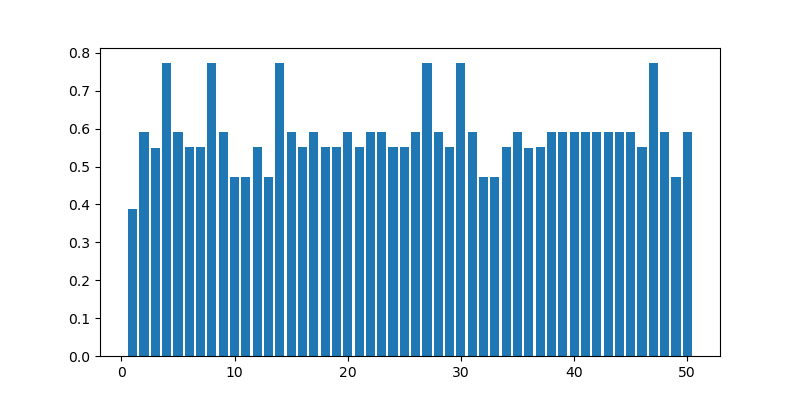

<BarContainer object of 50 artists>

In [31]:
iterations,vol_util=zip(*modified_volume_utilization.items())
fig = plt.figure(figsize=(8 ,4))
plt.bar(iterations,vol_util)

<IPython.core.display.Javascript object>


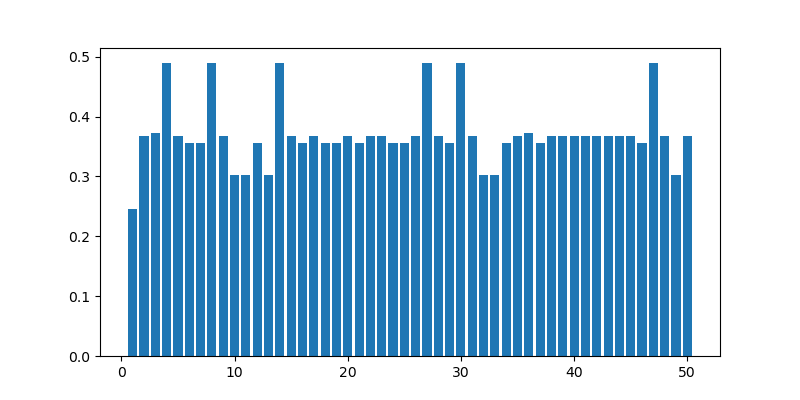

<BarContainer object of 50 artists>

In [32]:
iterations,weight_util=zip(*modified_weight_utilization.items())
fig = plt.figure(figsize=(8 ,4))
plt.bar(iterations,weight_util)

In [33]:
bins

[1, 2, 3, 4, 5, 6, 7]

In [34]:
print(set(list(x_iter[1][1].keys())))

{11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70}


In [35]:
print(set(IP_iter[1][1]))

{11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70}


In [36]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


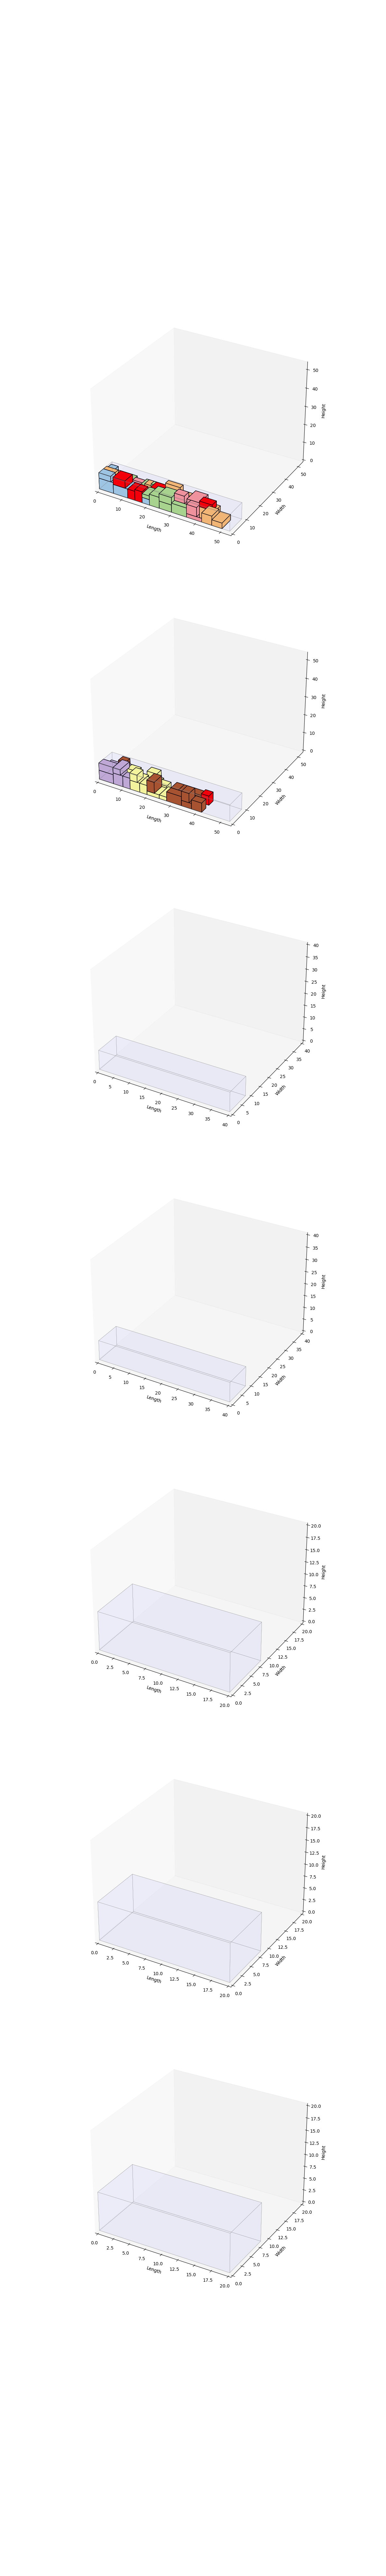

In [37]:


from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mycolorpy import colorlist as mcp

from itertools import product
%matplotlib inline
%matplotlib nbagg
from matplotlib import cm

c=mcp.gen_color(cmap="Paired",n=len(line_items))
colors=dict(zip(line_items,c))
color={}
for  i,value in line_items.items():
    for v in value:
        if stack_item[v]!=0:
            color[v]=colors[i]
        else:
            color[v]='red'



used_iter=max_iter_volume

flb={}
flt={}
frt={}
frb={}

rlb={}
rlt={}
rrt={}
rrb={}


nrows=len(bins)
fig = plt.figure(figsize=(12 ,80))


#colors={}
#classes=list(set(p_class.values()))
#size=len(set(p_class.values()))
#c=mcp.gen_color(cmap="Paired",n=len(classes))
#for i in range(len(classes)):
#    colors[classes[i]]=c[i]
#color={}
#for  i,value in p_class.items():
#    color[i]=colors[value]

# create list of corners
#z = list(product([-1,1], repeat=3))
for e in bins:

    x={}
    y={}
    z={}

    l={}
    w={}
    h={}


    ax = fig.add_subplot(nrows,1,e, projection='3d')
    FLB=(0,0,0)
    FLT=(0,0,H[e])
    FRT=(0,W[e],H[e])
    FRB=(0,W[e],0)

    RLB=(L[e],0,0)
    RLT=(L[e],0,H[e])
    RRT=(L[e],W[e],H[e])
    RRB=(L[e],W[e],0)

    bin_verts=[  [FLB,FLT,FRT,FRB],
             [FLB,FLT,RLT,RLB],
             [FLT,FRT,RRT,RLT],
             [RRT,FRT,FRB,RRB],
             [RLB,FLB,FRB,RRB],
             [RLB,RLT,RRT,RRB ]
             ]
    ax.set_xlim3d(0,L[e])
    ax.set_ylim3d(0,L[e])
    ax.set_zlim3d(0,L[e])
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')
    ax.set_zlabel('Height')
    ax.grid(False)
# plot sides
    ax.add_collection3d(Poly3DCollection(bin_verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.025))

  
    #for c in p_class:
        #c=mcp.gen_color(cmap="seismic",n=5)
#for e in IP_iter_update.keys():
 
    for i in IP_iter[used_iter][e]:
        x[i]=x_iter[used_iter][e][i]
        y[i]=y_iter[used_iter][e][i]
        z[i]=z_iter[used_iter][e][i]

        l[i]=l_iter[used_iter][e][i]
        w[i]=w_iter[used_iter][e][i]
        h[i]=h_iter[used_iter][e][i]

        flb[i]=(x[i],y[i],z[i])
        flt[i]=(x[i],y[i],z[i]+h[i])
        frt[i]=(x[i],y[i]+w[i],z[i]+h[i])
        frb[i]=(x[i],y[i]+w[i],z[i])

        rlb[i]=(x[i]+l[i],y[i],z[i])
        rlt[i]=(x[i]+l[i],y[i],z[i]+h[i])
        rrt[i]=(x[i]+l[i],y[i]+w[i],z[i]+h[i])
        rrb[i]=(x[i]+l[i],y[i]+w[i],z[i])

        box_verts=[  [flb[i],flt[i],frt[i],frb[i]],
                [flb[i],flt[i],rlt[i],rlb[i]],
                [flt[i],frt[i],rrt[i],rlt[i]],
                [rrt[i],frt[i],frb[i],rrb[i]],
                [rlb[i],flb[i],frb[i],rrb[i]],
                [rlb[i],rlt[i],rrt[i],rrb[i]]
                ]



        ax.add_collection3d(Poly3DCollection(box_verts,facecolors=color[i], linewidths=1, edgecolors='black', alpha=1))
        #ax.text((x[i]+l[i]),(y[i]+w[i]/2),(z[i]+h[i]/2),   i,'y', size=8, zorder=30,color='black')
        #ax.text((x[i]+l[i]/2),(y[i]),(z[i]+h[i]/2),   i,'x', size=8, zorder=30,color='black')
        #ax.text((x[i]+l[i]/2),(y[i]+w[i]/2),(z[i]+h[i]),   i,'x', size=8, zorder=30,color='black')
#'(%d, %d, %d), dir=%s' % (x, y, z, zdir)
 
"""
label1 = "FRONT"
label2 = "REAR"
#label3 = "BOTTOM"
ax.text(0, W/2, H/2, '%s' % (label1), size=10,zorder=7, color='black')
ax.text(L, W/2, H/2, '%s' % (label2), size=10,zorder=10, color='blue')
#ax.text(6, 2, 0, '%s' % (label3), size=20,zorder=5, color='blue')
#ax.view_init(elev=0, azim=45)
"""
plt.show()

In [38]:
bins

[1, 2, 3, 4, 5, 6, 7]

<IPython.core.display.Javascript object>


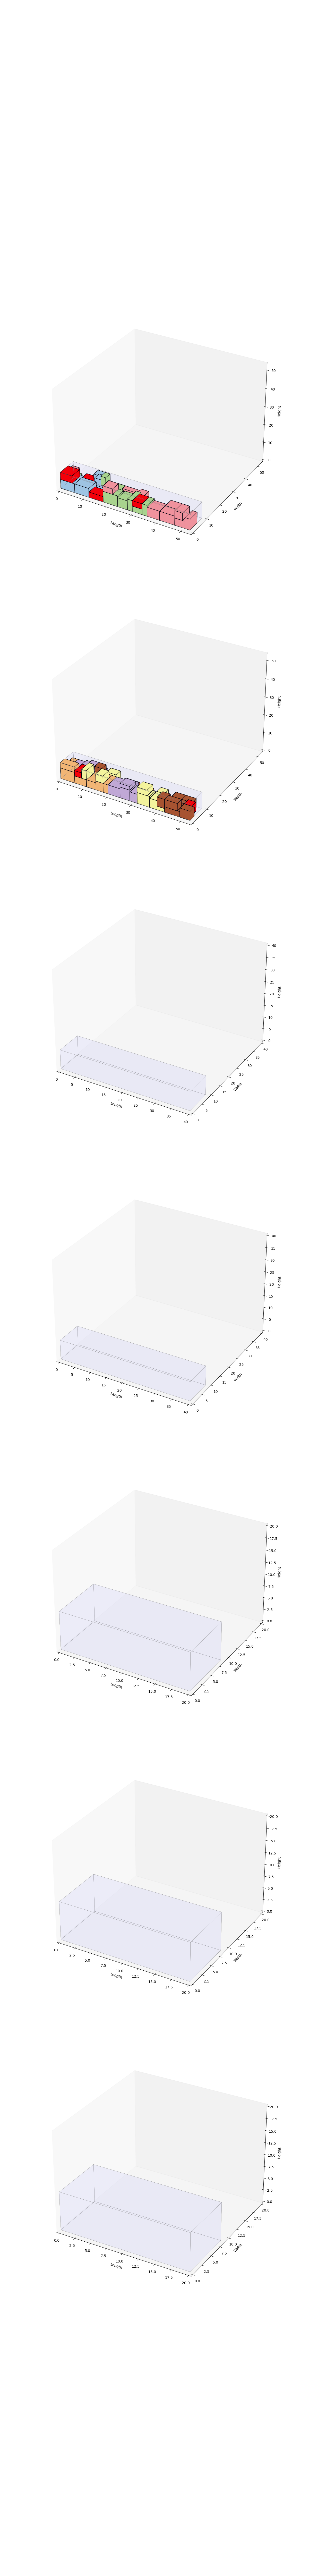

In [39]:


used_iter=2
flb={}
flt={}
frt={}
frb={}

rlb={}
rlt={}
rrt={}
rrb={}


nrows=len(bins)
fig = plt.figure(figsize=(12 ,100))




# create list of corners
#z = list(product([-1,1], repeat=3))
for e in bins:

    x={}
    y={}
    z={}

    l={}
    w={}
    h={}


    ax = fig.add_subplot(nrows,1,e, projection='3d')
    FLB=(0,0,0)
    FLT=(0,0,H[e])
    FRT=(0,W[e],H[e])
    FRB=(0,W[e],0)

    RLB=(L[e],0,0)
    RLT=(L[e],0,H[e])
    RRT=(L[e],W[e],H[e])
    RRB=(L[e],W[e],0)

    bin_verts=[  [FLB,FLT,FRT,FRB],
             [FLB,FLT,RLT,RLB],
             [FLT,FRT,RRT,RLT],
             [RRT,FRT,FRB,RRB],
             [RLB,FLB,FRB,RRB],
             [RLB,RLT,RRT,RRB ]
             ]
    ax.set_xlim3d(0,L[e])
    ax.set_ylim3d(0,L[e])
    ax.set_zlim3d(0,L[e])
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')
    ax.set_zlabel('Height')
    ax.grid(False)
# plot sides
    ax.add_collection3d(Poly3DCollection(bin_verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.025))

    for c in p_class:
        c=mcp.gen_color(cmap="seismic",n=5)
#for e in IP_iter_update.keys():

    for i in IP_iter[used_iter][e]:
        x[i]=x_iter[used_iter][e][i]
        y[i]=y_iter[used_iter][e][i]
        z[i]=z_iter[used_iter][e][i]

        l[i]=l_iter[used_iter][e][i]
        w[i]=w_iter[used_iter][e][i]
        h[i]=h_iter[used_iter][e][i]

        flb[i]=(x[i],y[i],z[i])
        flt[i]=(x[i],y[i],z[i]+h[i])
        frt[i]=(x[i],y[i]+w[i],z[i]+h[i])
        frb[i]=(x[i],y[i]+w[i],z[i])

        rlb[i]=(x[i]+l[i],y[i],z[i])
        rlt[i]=(x[i]+l[i],y[i],z[i]+h[i])
        rrt[i]=(x[i]+l[i],y[i]+w[i],z[i]+h[i])
        rrb[i]=(x[i]+l[i],y[i]+w[i],z[i])

        box_verts=[  [flb[i],flt[i],frt[i],frb[i]],
                [flb[i],flt[i],rlt[i],rlb[i]],
                [flt[i],frt[i],rrt[i],rlt[i]],
                [rrt[i],frt[i],frb[i],rrb[i]],
                [rlb[i],flb[i],frb[i],rrb[i]],
                [rlb[i],rlt[i],rrt[i],rrb[i]]
                ]



        ax.add_collection3d(Poly3DCollection(box_verts,facecolors=color[i], linewidths=1, edgecolors='black', alpha=1))
        #ax.text((x[i]+l[i]),(y[i]+w[i]/2),(z[i]+h[i]/2),   i,'y', size=8, zorder=30,color='black')
        #ax.text((x[i]+l[i]/2),(y[i]),(z[i]+h[i]/2),   i,'x', size=8, zorder=30,color='black')
        #ax.text((x[i]+l[i]/2),(y[i]+w[i]/2),(z[i]+h[i]),   i,'x', size=8, zorder=30,color='black')
#'(%d, %d, %d), dir=%s' % (x, y, z, zdir)

"""
label1 = "FRONT"
label2 = "REAR"
#label3 = "BOTTOM"
ax.text(0, W/2, H/2, '%s' % (label1), size=10,zorder=7, color='black')
ax.text(L, W/2, H/2, '%s' % (label2), size=10,zorder=10, color='blue')
#ax.text(6, 2, 0, '%s' % (label3), size=20,zorder=5, color='blue')
#ax.view_init(elev=0, azim=45)
"""
plt.show()

In [130]:
used_iter=13
for e in bins:
    for i in IP_iter[used_iter][e]:
            x[i]=x_iter[used_iter][e][i]
            y[i]=y_iter[used_iter][e][i]
            z[i]=z_iter[used_iter][e][i]

            l[i]=l_iter[used_iter][e][i]
            w[i]=w_iter[used_iter][e][i]
            h[i]=h_iter[used_iter][e][i]

            flb[i]=(x[i],y[i],z[i])
            flt[i]=(x[i],y[i],z[i]+h[i])
            frt[i]=(x[i],y[i]+w[i],z[i]+h[i])
            frb[i]=(x[i],y[i]+w[i],z[i])

            rlb[i]=(x[i]+l[i],y[i],z[i])
            rlt[i]=(x[i]+l[i],y[i],z[i]+h[i])
            rrt[i]=(x[i]+l[i],y[i]+w[i],z[i]+h[i])
            rrb[i]=(x[i]+l[i],y[i]+w[i],z[i])

In [133]:
z

{21: 0, 23: 0, 27: 0, 25: 0, 29: 3, 24: 0, 28: 0, 30: 5, 26: 6, 22: 5}

In [129]:
x_iter[13][2][22]

9

In [92]:
IU=[1,2,3]

In [93]:
for e in bins:
    
    for i in IU:
        IU.remove(i)
        print ('IU: ', IU)
    
    if IU!=[]:
        print(e)
        #continue
    

IU:  [2, 3]
IU:  [2]
1
IU:  []


In [94]:
IU

[]

In [95]:
initial_volume_e

{1: 4054.5, 2: 4054.5, 3: 2720.0, 4: 2720.0, 5: 1360.0, 6: 1360.0, 7: 1360.0}

In [96]:
volume_added_e

{}

In [ ]:
%%capture output --no-stderr

for it in range(1,iterations+1):

#    I={}
 #   for o in orders:
 #       I[o]=items_data[items_data["order"]==o].item.to_list()
# for each order
    #I=items_data.item.tolist() #list of items need to be packed
    for o in orders:

        I=items_data.item.tolist()

    IU=[x for x in I]
    print("I: ",I)
    print("IU: ",IU)

    #vehicle level properties
    IP_e={} #item packed in bins

    x_e={} #x coordinate of insertion point (RBL) of items in bins
    y_e={} #y coordinate of insertion point (RBL) of items in bins
    z_e={} #z coordinate of insertion point (RBL) of items in bins

    l_e={} #length of items in bins
    w_e={} #width of items in bins
    h_e={} #height of items in bins

    volume_utilization_e={} #volume utilized in bins
    weight_utilization_e={} #weight utilized in bins

    volume_e= {e:0 for e in bins} #volume loaded in bin
    weight_e= {e:0 for e in bins} #weight loaded in bin

    c_gravity_y_e={} #center of gravity along width of bins
    dev_gravity_center_e={}  #deviation of center of gravity along width of bins

    volume_loaded_e={}#volume loaded in bins
    weight_loaded_e={}#volume loaded in bins

    c_gravity_item_x={} #center of gravity of items along length of bins
    c_gravity_item_y={} #center of gravity of items along width of bins
    c_gravity_item_z={} #center of gravity of items along height of bins

    used_bins=[]

    unused_bins=[b for b in bins]

    for e in bins:
        #if IU==[]:
            #unused_bins.remove(e)
            #continue
        l={} #length of items
        w={} #width  of items
        h={} #height  of items
        o={} #orientation of items
        sa={} #surface area of items
        sa_p={} #surface area available at potential point p

        x={} #x coordinate of insertion point (RBL) of items
        y={} #y coordinate of insertion point (RBL) of items
        z={} #z coordinate of insertion point (RBL) of items

        stack_p={} #stackability at potential point p

        #if total_volume_e[e]<volume_capacity[e]:
        print("____packing starts______")
        print(e, " in ", bins)
        print('IU: ', IU)

       #start with (0,0,0) in the bin
        P=[(0,0,0)] #starting potential point in
        print("  **** potential points ", P)
        under_p={} # item under potential point p

        l_available_p={} #lenght available at potential point p
        w_available_p={} #width available at potential point p
        l_available_p[(0,0,0)]=L[e] #initial available length
        w_available_p[(0,0,0)]=W[e] #initial available wdidth

        print('l_available_p', l_available_p)
        print('w_available_p', w_available_p)

        sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
        under_p[(0,0,0)]=0 #item under p

        #length, width, height of initial p
        l[0]=L[e] #lenght of item 0
        w[0]=W[e]
        h[0]=H[e]

        #items packed list, initial list is empty
        IP=[]
        IUU=[]

        #each bin is divided in four zones. Create a list of size 4 to compute weight in
        #each zone
        weights_in_zones=[0]*zones #weight loaded in each zone =0
        weight_by_item_in_zones={} #weight added by items in each zone
        weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

        print("######################################################")
        while IU!=[] :
            print("===while IU!= 0" ,IU)
            print("===IU:" ,IU)
            print('===available potential points: ',P)
            I_retry=[] #items that needs to be retried packing

            loaded_weight_p={} #weight loaded at potential point p

            #IU=IU+IUU


            for i in IU:
                if volume_e[e]+volume[i]>volume_capacity[e]:
                    IUU.append(i)


                else:
                    print("### Evaluation box ", i, "in IU ",IU)
                    o[i]=random.choice(orientations)

                    if o[i]=='o1' :
                        l[i]=ll[i]
                        w[i]=ww[i]
                        h[i]=hh[i]
                    if o[i]=='o2' :
                        l[i]=ww[i]
                        w[i]=ll[i]
                        h[i]=hh[i]
                    if o[i]=='o3' :
                        l[i]=ww[i]
                        w[i]=hh[i]
                        h[i]=ll[i]
                    if o[i]=='o4' :
                        l[i]=hh[i]
                        w[i]=ww[i]
                        h[i]=ll[i]
                    if o[i]=='o5' :
                        l[i]=hh[i]
                        w[i]=ll[i]
                        h[i]=ww[i]
                    if o[i]=='o6' :
                        l[i]=ll[i]
                        w[i]=hh[i]
                        h[i]=ww[i]

                    sa[i]=l[i]*w[i]

                    print(" length, width, and height " , l,w,h)

                    p_feasible=[]

                    print(" ====start Loading ")
                    print('for ', i, ' in ', IU)
                    #print('i : : ',i)
                    #MPL_x= max([x[k]+l[k] for k in IP])
                   #MPL_y= max([y[k]+w[k] for k in IP])
                    #MPL_y= max([h[k]+h[k] for k in IP])

                        #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                    sa_ratio=0
                    for p in P:
                        print('----start evaluating P')
                        print('for ',p,' in ', P)

                       # zone_ratio=[]
                        loaded_weight=[]

                        #print('Available Potentail points', P)
                        #print('test Potential point: ',p)

                        if p[0]+l[i] <=L[e]/4:
                            print('first weight condition')
                            zone_ratio=[1,0,0,0]
                        if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                            print('2 nd weight condition')
                            zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                        if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                            print('3 rd weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('4th weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                            print('5th weight condition')
                            zone_ratio=[0,1,0,0]
                        if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                            print('6th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                            print('7th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                            print('8th weight condition')
                            zone_ratio=[0,0,1,0]
                        if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('9th weight condition')
                            zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                            print('10th weight condition')
                            zone_ratio=[0,0,0,1]
                        loaded_weight=[x*weight[i] for x in zone_ratio]
                            #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                            #print('weight in zone ',pp,weights_in_zones[pp]
                        loaded_weight_p[p]=loaded_weight
                        print("loaded weight for", p, ":",loaded_weight_p )



                        print('------evaluating loaded weigh.... ')
                        if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                            print('....loaded weight criterion worked')
                            print('evluating length and width of bin....  ')
                            #print('for, p[0]: ',p[0])

                            if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                print("...bin length and bin width criteria worked")
                                #if sa_p[p]>sa[i]:
                                print('evluating availale_lenght and availabl_width....  ')
                                print('l_available', l_available_p)
                                if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                    print("...availale_length and availabl_width criteria worked")
                                    print("Evaluating surface area....")
                                    if sa[i]/sa_p[p]>=sa_ratio:
                                        print("...surface criterion worked")
                                        sa_ratio=sa[i]/sa_p[p]
                                        p_feasible.append(p)
                                        print('----sa ratio:', sa_ratio)


                    print('-----feaible p:', p_feasible)
                    if p_feasible==[]:
                        I_retry.append(i)
                        print("no feasible potential points for: ", i)
                        print('I_retry: ',I_retry)
                        continue

                    elif len(p_feasible)>1:
                            x_p= min([point[0] for point in p_feasible])
                            x_y=min([point[1] for point in p_feasible])
                            x_z=min([point[2] for point in p_feasible])
                            #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                            p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                    elif len(p_feasible)==1:
                            p_best=p_feasible[0]

                    if p_best:
                        print('b===est potential point p_best: ',p_best )

                        weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                        weight_by_item_in_zones[i]= weights_in_zones


                        print('best potential point: ',p_best )
                        #item to be placed at x[i],y[i],z[i]
                        x[i]=p_best[0]
                        y[i]=p_best[1]
                        z[i]=p_best[2]

                        l[i]=l[i]
                        w[i]=w[i]
                        h[i]=h[i]

                        #create new potential points
                        P.append((x[i]+l[i],y[i],z[i]))
                        P.append((x[i],y[i]+w[i],z[i]))
                        P.append((x[i],y[i],z[i]+h[i]))
                        print ("*** P after adding new  potential points :", P)

                        sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                        under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i],z[i]+h[i])]=i

                        #stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


                        l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                        l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                        l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                        print('l_available_p', l_available_p)
                        print('w_available_p', w_available_p)

                        w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                        w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                        w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]


                        P.remove(p_best)
                        print("+++++ removed potential points: ", p_best)
                        print ("**** P after removing p_best  potential points :", P)

                        if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                            P.remove((x[i]+l[i],y[i],z[i]))
                        if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                            P.remove((x[i],y[i]+w[i],z[i]))

                        for pp, t1 in enumerate(P):
                            for t2 in P[pp+1:]:
                                if t1[1:]==t2[1:]:
                                    if t1[0]<t2[0]:
                                        P.remove(t2)
                                    else:
                                        P.remove(t1)
                        for ppp, tt1 in enumerate(P):
                            for tt2 in P[ppp+1:]:
                                if tt1[0::2]==tt2[0::2]:
                                    if tt1[1]<tt2[1]:
                                        P.remove(tt2)
                                    else:
                                        P.remove(tt1)

                        IP.append(i)

                        updated_volume=volume_e[e]+volume[i]
                        updated_weight=weight_e[e]+weight[i]
                        volume_e.update({e:updated_volume})
                        weight_e.update({e:updated_weight})

                        print("@@@@ IP : ",IP)
                        #volume_loaded.append(volume[i])
                        #weight_loaded.append(weight[i])
                        c_gravity_item_x[i]=x[i]+l[i]/2
                        c_gravity_item_y[i]=y[i]+w[i]/2
                        c_gravity_item_z[i]=z[i]+h[i]/2
                        print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

            print('Before going to new bin or retrying:')
            print('I_retry: ',I_retry)
            print('IU: ',IU)
            print('IP: ',IP)
            print('IUU: ',IUU)
            print("=============IU,IP,I_retry")
            if  I_retry==[] or  set(I_retry)==set(IU):
                IU=[x for x in IU if x not in IP]
                #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                print("break")

                print(IU,IP,I_retry)

                break

            if I_retry!=[] and set(I_retry)!=set(IU):
                #if I_retry!=IU:
                IU=[x for x in I_retry]
                print('going to retry')

                print(IU,IP,I_retry)

                continue

        IP_e[e]=IP
        print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
        print("&&&& c_gravity_item_y: ",c_gravity_item_y )

        x_e[e]=x
        y_e[e]=y
        z_e[e]=z


        l_e[e]=l
        w_e[e]=w
        h_e[e]=h

        if IP_e[e]!=[]:
            c_gravity_y_e[e]=sum(c_gravity_item_y[i]*weight[i] for i in IP_e[e])/sum(weight[i] for i in IP_e[e])
            #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
            print("===================================== c_gravity_y_e :",c_gravity_y_e)
        else:
            c_gravity_y_e[e]=0
            #dev_gravity_center[e]=INF
        #print(c_gravity_y[e])
        #if W[e]*(1/3) <c_gravity_y[it]<W[e]*(2/3):
        #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
        #else:
        #    dev_gravity_center[e]="too far"

        volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
        volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

        weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
        weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]
        used_bins.append(e)

    print('after each iteration:')
    print('IP_e: ',IP_e)
    IP_iter[it]=IP_e

    used_bins_iter[it]=used_bins
    #unused_bins_iter[it]=unused_bins

    volume_utilization_iter[it]=volume_utilization_e
    weight_utilization_iter[it]=weight_utilization_e
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_e
    y_iter[it]=y_e
    z_iter[it]=z_e

    l_iter[it]=l_e
    w_iter[it]=w_e
    h_iter[it]=h_e

print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


In [ ]:
%%capture output --no-stderr

for it in range(1,iterations+1):

#    I={}
 #   for o in orders:
 #       I[o]=items_data[items_data["order"]==o].item.to_list()
# for each order
    #I=items_data.item.tolist() #list of items need to be packed
    for o in orders:

        I=items_data.item.tolist()

    IU=[x for x in I]
    print("I: ",I)
    print("IU: ",IU)

    #vehicle level properties
    IP_e={} #item packed in bins

    x_e={} #x coordinate of insertion point (RBL) of items in bins
    y_e={} #y coordinate of insertion point (RBL) of items in bins
    z_e={} #z coordinate of insertion point (RBL) of items in bins

    l_e={} #length of items in bins
    w_e={} #width of items in bins
    h_e={} #height of items in bins

    volume_utilization_e={} #volume utilized in bins
    weight_utilization_e={} #weight utilized in bins

    volume_e= {e:0 for e in bins} #volume loaded in bin
    weight_e= {e:0 for e in bins} #weight loaded in bin

    c_gravity_y_e={} #center of gravity along width of bins
    dev_gravity_center_e={}  #deviation of center of gravity along width of bins

    volume_loaded_e={}#volume loaded in bins
    weight_loaded_e={}#volume loaded in bins

    c_gravity_item_x={} #center of gravity of items along length of bins
    c_gravity_item_y={} #center of gravity of items along width of bins
    c_gravity_item_z={} #center of gravity of items along height of bins

    used_bins=[]

    unused_bins=[b for b in bins]

    for e in bins:
        P_items={}
        #if IU==[]:
            #unused_bins.remove(e)
            #continue
        l={} #length of items
        w={} #width  of items
        h={} #height  of items
        o={} #orientation of items
        sa={} #surface area of items
        sa_p={} #surface area available at potential point p

        x={} #x coordinate of insertion point (RBL) of items
        y={} #y coordinate of insertion point (RBL) of items
        z={} #z coordinate of insertion point (RBL) of items

        stack_p={} #stackability at potential point p

        #if total_volume_e[e]<volume_capacity[e]:
        print("____packing starts______")
        print(e, " in ", bins)
        print('IU: ', IU)

       #start with (0,0,0) in the bin
        P=[(0,0,0)] #starting potential point in
        P_items[0]=P
        print("  **** potential points ", P)
        under_p={} # item under potential point p

        l_available_p={} #lenght available at potential point p
        w_available_p={} #width available at potential point p
        l_available_p[(0,0,0)]=L[e] #initial available length
        w_available_p[(0,0,0)]=W[e] #initial available wdidth

        sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
        under_p[(0,0,0)]=0 #item under p

        #length, width, height of initial p
        l[0]=L[e] #lenght of item 0
        w[0]=W[e]
        h[0]=H[e]

        #items packed list, initial list is empty
        IP=[]
        IUU=[]

        #each bin is divided in four zones. Create a list of size 4 to compute weight in
        #each zone
        weights_in_zones=[0]*zones #weight loaded in each zone =0
        weight_by_item_in_zones={} #weight added by items in each zone
        weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

        print("######################################################")
        while IU!=[] :
            print("===while IU!= 0" ,IU)
            print("===IU:" ,IU)
            print('===available potential points: ',P)
            I_retry=[] #items that needs to be retried packing

            loaded_weight_p={} #weight loaded at potential point p

            #IU=IU+IUU


            for i in IU:
                if volume_e[e]+volume[i]>volume_capacity[e]:
                    IUU.append(i)
                    


                else:
                    print("### Evaluation box ", i, "in IU ",IU)
                    o[i]=random.choice(orientations)

                    if o[i]=='o1' :
                        l[i]=ll[i]
                        w[i]=ww[i]
                        h[i]=hh[i]
                    if o[i]=='o2' :
                        l[i]=ww[i]
                        w[i]=ll[i]
                        h[i]=hh[i]
                    if o[i]=='o3' :
                        l[i]=ww[i]
                        w[i]=hh[i]
                        h[i]=ll[i]
                    if o[i]=='o4' :
                        l[i]=hh[i]
                        w[i]=ww[i]
                        h[i]=ll[i]
                    if o[i]=='o5' :
                        l[i]=hh[i]
                        w[i]=ll[i]
                        h[i]=ww[i]
                    if o[i]=='o6' :
                        l[i]=ll[i]
                        w[i]=hh[i]
                        h[i]=ww[i]

                    sa[i]=l[i]*w[i]

                    print(" length, width, and height " , l,w,h)

                    p_feasible=[]

                    print(" ====start Loading ")
                    print('for ', i, ' in ', IU)
                    #print('i : : ',i)
                    #MPL_x= max([x[k]+l[k] for k in IP])
                   #MPL_y= max([y[k]+w[k] for k in IP])
                    #MPL_y= max([h[k]+h[k] for k in IP])

                        #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                    sa_ratio=0
                    for p in P:
                        print('----start evaluating P')
                        print('for ',p,' in ', P)

                       # zone_ratio=[]
                        loaded_weight=[]

                        #print('Available Potentail points', P)
                        #print('test Potential point: ',p)

                        if p[0]+l[i] <=L[e]/4:
                            print('first weight condition')
                            zone_ratio=[1,0,0,0]
                        if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                            print('2 nd weight condition')
                            zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                        if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                            print('3 rd weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('4th weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                            print('5th weight condition')
                            zone_ratio=[0,1,0,0]
                        if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                            print('6th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                            print('7th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                            print('8th weight condition')
                            zone_ratio=[0,0,1,0]
                        if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('9th weight condition')
                            zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                            print('10th weight condition')
                            zone_ratio=[0,0,0,1]
                        loaded_weight=[x*weight[i] for x in zone_ratio]
                            #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                            #print('weight in zone ',pp,weights_in_zones[pp]
                        loaded_weight_p[p]=loaded_weight
                        print("loaded weight for", p, ":",loaded_weight_p )



                        print('------evaluating loaded weigh.... ')
                        if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                            print('....loaded weight criterion worked')
                            print('evluating length and width of bin....  ')
                            #print('for, p[0]: ',p[0])

                            if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                print("...bin length and bin width criteria worked")
                                #if sa_p[p]>sa[i]:
                                print('evluating availale_lenght and availabl_width....  ')
                                if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                    print("...availale_length and availabl_width criteria worked")
                                    print("Evaluating surface area....")
                                    if sa[i]/sa_p[p]>=sa_ratio:
                                        print("...surface criterion worked")
                                        sa_ratio=sa[i]/sa_p[p]
                                        p_feasible.append(p)
                                        print('----sa ratio:', sa_ratio)


                    print('-----feaible p:', p_feasible)
                    if p_feasible==[]:
                        I_retry.append(i)
                        print("no feasible potential points for: ", i)
                        print('I_retry: ',I_retry)
                        continue

                    elif len(p_feasible)>1:
                            x_p= min([point[0] for point in p_feasible])
                            x_y=min([point[1] for point in p_feasible])
                            x_z=min([point[2] for point in p_feasible])
                            #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                            p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                    elif len(p_feasible)==1:
                            p_best=p_feasible[0]

                    if p_best:
                        print('b===est potential point p_best: ',p_best )

                        weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                        weight_by_item_in_zones[i]= weights_in_zones


                        print('best potential point: ',p_best )
                        #item to be placed at x[i],y[i],z[i]
                        x[i]=p_best[0]
                        y[i]=p_best[1]
                        z[i]=p_best[2]

                        l[i]=l[i]
                        w[i]=w[i]
                        h[i]=h[i]

                        #create new potential points
                        P.append((x[i]+l[i],y[i],z[i]))
                        P.append((x[i],y[i]+w[i],z[i]))
                        P.append((x[i],y[i],z[i]+h[i]))

                        print ("*** P after adding new  potential points :", P)
                        p_for_adding_i=[(x[i]+l[i],y[i],z[i]),(x[i],y[i]+w[i],z[i]),(x[i],y[i],z[i]+h[i]]



                        sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                        under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i],z[i]+h[i])]=i

                        #stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


                        l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                        l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                        l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                        w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                        w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                        w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]


                        P.remove(p_best)
                        print("+++++ removed potential points: ", p_best)
                        print ("**** P after removing p_best  potential points :", P)

                        if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                            P.remove((x[i]+l[i],y[i],z[i]))
                            p_for_adding_i.remove((x[i]+l[i],y[i],z[i]))


                        if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                            P.remove((x[i],y[i]+w[i],z[i]))
                            p_for_adding_i.remove((x[i],y[i]+w[i],z[i]))

                        for pp, t1 in enumerate(P):
                            for t2 in P[pp+1:]:
                                if t1[1:]==t2[1:]:
                                    if t1[0]<t2[0]:
                                        P.remove(t2)
                                        p_for_adding_i.remove()
                                    else:
                                        P.remove(t1)
                        for ppp, tt1 in enumerate(P):
                            for tt2 in P[ppp+1:]:
                                if tt1[0::2]==tt2[0::2]:
                                    if tt1[1]<tt2[1]:
                                        P.remove(tt2)
                                    else:
                                        P.remove(tt1)

                        IP.append(i)

                        updated_volume=volume_e[e]+volume[i]
                        updated_weight=weight_e[e]+weight[i]
                        volume_e.update({e:updated_volume})
                        weight_e.update({e:updated_weight})

                        print("@@@@ IP : ",IP)
                        #volume_loaded.append(volume[i])
                        #weight_loaded.append(weight[i])
                        c_gravity_item_x[i]=x[i]+l[i]/2
                        c_gravity_item_y[i]=y[i]+w[i]/2
                        c_gravity_item_z[i]=z[i]+h[i]/2
                        print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

            print('Before going to new bin or retrying:')
            print('I_retry: ',I_retry)
            print('IU: ',IU)
            print('IP: ',IP)
            print('IUU: ',IUU)
            print("=============IU,IP,I_retry")
            if  I_retry==[] or  set(I_retry)==set(IU):
                IU=[x for x in IU if x not in IP]
                #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                print("break")

                print(IU,IP,I_retry)

                break

            if I_retry!=[] and set(I_retry)!=set(IU):
                #if I_retry!=IU:
                IU=[x for x in I_retry]
                print('going to retry')

                print(IU,IP,I_retry)

                continue

        IP_e[e]=IP
        print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
        print("&&&& c_gravity_item_y: ",c_gravity_item_y )

        x_e[e]=x
        y_e[e]=y
        z_e[e]=z


        l_e[e]=l
        w_e[e]=w
        h_e[e]=h

        if IP_e[e]!=[]:
            c_gravity_y_e[e]=sum(c_gravity_item_y[i]*weight[i] for i in IP_e[e])/sum(weight[i] for i in IP_e[e])
            #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
            print("===================================== c_gravity_y_e :",c_gravity_y_e)
        else:
            c_gravity_y_e[e]=0
            #dev_gravity_center[e]=INF
        #print(c_gravity_y[e])
        #if W[e]*(1/3) <c_gravity_y[it]<W[e]*(2/3):
        #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
        #else:
        #    dev_gravity_center[e]="too far"

        volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
        volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

        weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
        weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]
        used_bins.append(e)

    print('after each iteration:')
    print('IP_e: ',IP_e)
    IP_iter[it]=IP_e

    used_bins_iter[it]=used_bins
    #unused_bins_iter[it]=unused_bins

    volume_utilization_iter[it]=volume_utilization_e
    weight_utilization_iter[it]=weight_utilization_e
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_e
    y_iter[it]=y_e
    z_iter[it]=z_e

    l_iter[it]=l_e
    w_iter[it]=w_e
    h_iter[it]=h_e

print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


In [ ]:
%%capture output --no-stderr

for it in range(1,iterations+1):

#    I={}
 #   for o in orders:
 #       I[o]=items_data[items_data["order"]==o].item.to_list()
# for each order
    #I=items_data.item.tolist() #list of items need to be packed
    IU=[x for x in I]
    print("I: ",I)
    print("IU: ",IU)

    #vehicle level properties
    IP_e={} #item packed in bins

    x_e={} #x coordinate of insertion point (RBL) of items in bins
    y_e={} #y coordinate of insertion point (RBL) of items in bins
    z_e={} #z coordinate of insertion point (RBL) of items in bins

    l_e={} #length of items in bins
    w_e={} #width of items in bins
    h_e={} #height of items in bins

    volume_utilization_e={} #volume utilized in bins
    weight_utilization_e={} #weight utilized in bins

    volume_e= {e:0 for e in bins} #volume loaded in bin
    weight_e= {e:0 for e in bins} #weight loaded in bin

    c_gravity_y_e={} #center of gravity along width of bins
    dev_gravity_center_e={}  #deviation of center of gravity along width of bins

    volume_loaded_e={}#volume loaded in bins
    weight_loaded_e={}#volume loaded in bins

    c_gravity_item_x={} #center of gravity of items along length of bins
    c_gravity_item_y={} #center of gravity of items along width of bins
    c_gravity_item_z={} #center of gravity of items along height of bins

    used_bins=[]

    unused_bins=[b for b in bins]

    for e in bins:
        #if IU==[]:
            #unused_bins.remove(e)
            #continue
        l={} #length of items
        w={} #width  of items
        h={} #height  of items
        o={} #orientation of items
        sa={} #surface area of items
        sa_p={} #surface area available at potential point p

        x={} #x coordinate of insertion point (RBL) of items
        y={} #y coordinate of insertion point (RBL) of items
        z={} #z coordinate of insertion point (RBL) of items

        stack_p={} #stackability at potential point p

        #if total_volume_e[e]<volume_capacity[e]:
        print("____packing starts______")
        print(e, " in ", bins)
        print('IU: ', IU)

       #start with (0,0,0) in the bin
        P=[(0,0,0)] #starting potential point in
        print("  **** potential points ", P)
        under_p={} # item under potential point p

        l_available_p={} #lenght available at potential point p
        w_available_p={} #width available at potential point p
        l_available_p[(0,0,0)]=L[e] #initial available length
        w_available_p[(0,0,0)]=W[e] #initial available wdidth

        sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
        under_p[(0,0,0)]=0 #item under p

        #length, width, height of initial p
        l[0]=L[e] #lenght of item 0
        w[0]=W[e]
        h[0]=H[e]

        #items packed list, initial list is empty
        IP=[]
        IUU=[]

        #each bin is divided in four zones. Create a list of size 4 to compute weight in
        #each zone
        weights_in_zones=[0]*zones #weight loaded in each zone =0
        weight_by_item_in_zones={} #weight added by items in each zone
        weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

        print("######################################################")
        while IU!=[] :
            print("===while IU!= 0" ,IU)
            print("===IU:" ,IU)
            print('===available potential points: ',P)
            I_retry=[] #items that needs to be retried packing

            loaded_weight_p={} #weight loaded at potential point p

            #IU=IU+IUU

            
            for i in IU:
                print('for i in IU', (i, IU))
                if volume_e[e]+volume[i]>volume_capacity[e]:
                    IUU.append(i)


                else:
                    print("### Evaluation box ", i, "in IU ",IU)
                    o[i]=random.choice(orientations)

                    if o[i]=='o1' :
                        l[i]=ll[i]
                        w[i]=ww[i]
                        h[i]=hh[i]
                    if o[i]=='o2' :
                        l[i]=ww[i]
                        w[i]=ll[i]
                        h[i]=hh[i]
                    if o[i]=='o3' :
                        l[i]=ww[i]
                        w[i]=hh[i]
                        h[i]=ll[i]
                    if o[i]=='o4' :
                        l[i]=hh[i]
                        w[i]=ww[i]
                        h[i]=ll[i]
                    if o[i]=='o5' :
                        l[i]=hh[i]
                        w[i]=ll[i]
                        h[i]=ww[i]
                    if o[i]=='o6' :
                        l[i]=ll[i]
                        w[i]=hh[i]
                        h[i]=ww[i]

                    sa[i]=l[i]*w[i]

                    print(" length, width, and height " , l,w,h)

                    p_feasible=[]

                    print(" ====start Loading ")
                    print('for ', i, ' in ', IU)
                    #print('i : : ',i)
                    #MPL_x= max([x[k]+l[k] for k in IP])
                   #MPL_y= max([y[k]+w[k] for k in IP])
                    #MPL_y= max([h[k]+h[k] for k in IP])

                        #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                    sa_ratio=0
                    for p in P:
                        print('----start evaluating P')
                        print('for ',p,' in ', P)

                       # zone_ratio=[]
                        loaded_weight=[]

                        #print('Available Potentail points', P)
                        #print('test Potential point: ',p)

                        if p[0]+l[i] <=L[e]/4:
                            print('first weight condition')
                            zone_ratio=[1,0,0,0]
                        if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                            print('2 nd weight condition')
                            zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                        if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                            print('3 rd weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('4th weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                            print('5th weight condition')
                            zone_ratio=[0,1,0,0]
                        if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                            print('6th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                            print('7th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                            print('8th weight condition')
                            zone_ratio=[0,0,1,0]
                        if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('9th weight condition')
                            zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                            print('10th weight condition')
                            zone_ratio=[0,0,0,1]
                        loaded_weight=[x*weight[i] for x in zone_ratio]
                            #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                            #print('weight in zone ',pp,weights_in_zones[pp]
                        loaded_weight_p[p]=loaded_weight
                        print("loaded weight for", p, ":",loaded_weight_p )



                        print('------evaluating loaded weigh.... ')
                        if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                            print('....loaded weight criterion worked')
                            print('evluating length and width of bin....  ')
                            #print('for, p[0]: ',p[0])

                            if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                print("...bin length and bin width criteria worked")
                                #if sa_p[p]>sa[i]:
                                print('evluating availale_lenght and availabl_width....  ')
                                if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                    print("...availale_length and availabl_width criteria worked")
                                    print("Evaluating surface area....")
                                    if sa[i]/sa_p[p]>=sa_ratio:
                                        print("...surface criterion worked")
                                        sa_ratio=sa[i]/sa_p[p]
                                        p_feasible.append(p)
                                        print('----sa ratio:', sa_ratio)


                    print('-----feaible p:', p_feasible)
                    if p_feasible==[]:
                        I_retry.append(i)
                        print("no feasible potential points for: ", i)
                        print('I_retry: ',I_retry)
                        continue

                    elif len(p_feasible)>1:
                            x_p= min([point[0] for point in p_feasible])
                            x_y=min([point[1] for point in p_feasible])
                            x_z=min([point[2] for point in p_feasible])
                            #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                            p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                    elif len(p_feasible)==1:
                            p_best=p_feasible[0]

                    if p_best:
                        print('b===est potential point p_best: ',p_best )

                        weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                        weight_by_item_in_zones[i]= weights_in_zones


                        print('best potential point: ',p_best )
                        #item to be placed at x[i],y[i],z[i]
                        x[i]=p_best[0]
                        y[i]=p_best[1]
                        z[i]=p_best[2]

                        l[i]=l[i]
                        w[i]=w[i]
                        h[i]=h[i]

                        #create new potential points
                        P.append((x[i]+l[i],y[i],z[i]))
                        P.append((x[i],y[i]+w[i],z[i]))
                        P.append((x[i],y[i],z[i]+h[i]))
                        print ("*** P after adding new  potential points :", P)

                        sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                        under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i],z[i]+h[i])]=i

                        #stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


                        l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                        l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                        l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                        w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                        w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                        w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]


                        P.remove(p_best)
                        print("+++++ removed potential points: ", p_best)
                        print ("**** P after removing p_best  potential points :", P)

                        if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                            P.remove((x[i]+l[i],y[i],z[i]))
                        if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                            P.remove((x[i],y[i]+w[i],z[i]))

                        for pp, t1 in enumerate(P):
                            for t2 in P[pp+1:]:
                                if t1[1:]==t2[1:]:
                                    if t1[0]<t2[0]:
                                        P.remove(t2)
                                    else:
                                        P.remove(t1)
                        for ppp, tt1 in enumerate(P):
                            for tt2 in P[ppp+1:]:
                                if tt1[0::2]==tt2[0::2]:
                                    if tt1[1]<tt2[1]:
                                        P.remove(tt2)
                                    else:
                                        P.remove(tt1)

                        IP.append(i)

                        updated_volume=volume_e[e]+volume[i]
                        updated_weight=weight_e[e]+weight[i]
                        volume_e.update({e:updated_volume})
                        weight_e.update({e:updated_weight})

                        print("@@@@ IP : ",IP)
                        #volume_loaded.append(volume[i])
                        #weight_loaded.append(weight[i])
                        c_gravity_item_x[i]=x[i]+l[i]/2
                        c_gravity_item_y[i]=y[i]+w[i]/2
                        c_gravity_item_z[i]=z[i]+h[i]/2
                        print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

            print('Before going to new bin or re-trying:')
            print('I_retry: ',I_retry)
            print('IU: ',IU)
            print('IP: ',IP)
            print('IUU: ',IUU)
            print("=============IU,IP,I_retry")
            if  I_retry==[] or  set(I_retry)==set(IU):
                IU=[x for x in IU if x not in IP]
                #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                print("break")

                print(IU,IP,I_retry)

                break

            if I_retry!=[] and set(I_retry)!=set(IU):
                #if I_retry!=IU:
                IU=[x for x in I_retry]
                print('going to retry')

                print(IU,IP,I_retry)

                continue

        IP_e[e]=IP
        print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
        print("&&&& c_gravity_item_y: ",c_gravity_item_y )

        x_e[e]=x
        y_e[e]=y
        z_e[e]=z


        l_e[e]=l
        w_e[e]=w
        h_e[e]=h

        if IP_e[e]!=[]:
            c_gravity_y_e[e]=sum(c_gravity_item_y[i]*weight[i] for i in IP_e[e])/sum(weight[i] for i in IP_e[e])
            #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
            print("===================================== c_gravity_y_e :",c_gravity_y_e)
        else:
            c_gravity_y_e[e]=0
            #dev_gravity_center[e]=INF
        #print(c_gravity_y[e])
        #if W[e]*(1/3) <c_gravity_y[it]<W[e]*(2/3):
        #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
        #else:
        #    dev_gravity_center[e]="too far"

        volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
        volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

        weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
        weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]
        used_bins.append(e)

    print('after each iteration:')
    print('IP_e: ',IP_e)
    IP_iter[it]=IP_e

    used_bins_iter[it]=used_bins
    #unused_bins_iter[it]=unused_bins

    volume_utilization_iter[it]=volume_utilization_e
    weight_utilization_iter[it]=weight_utilization_e
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_e
    y_iter[it]=y_e
    z_iter[it]=z_e

    l_iter[it]=l_e
    w_iter[it]=w_e
    h_iter[it]=h_e

print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


In [ ]:
%%capture output --no-stderr

for it in range(1,iterations+1):

#    I={}
 #   for o in orders:
 #       I[o]=items_data[items_data["order"]==o].item.to_list()
# for each order
    #I=items_data.item.tolist() #list of items need to be packed
    IU=[x for x in I]
    print("I: ",I)
    print("IU: ",IU)

    #vehicle level properties
    IP_e={} #item packed in bins

    x_e={} #x coordinate of insertion point (RBL) of items in bins
    y_e={} #y coordinate of insertion point (RBL) of items in bins
    z_e={} #z coordinate of insertion point (RBL) of items in bins

    l_e={} #length of items in bins
    w_e={} #width of items in bins
    h_e={} #height of items in bins

    volume_utilization_e={} #volume utilized in bins
    weight_utilization_e={} #weight utilized in bins

    volume_e= {e:0 for e in bins} #volume loaded in bin
    weight_e= {e:0 for e in bins} #weight loaded in bin

    c_gravity_y_e={} #center of gravity along width of bins
    dev_gravity_center_e={}  #deviation of center of gravity along width of bins

    volume_loaded_e={}#volume loaded in bins
    weight_loaded_e={}#volume loaded in bins

    c_gravity_item_x={} #center of gravity of items along length of bins
    c_gravity_item_y={} #center of gravity of items along width of bins
    c_gravity_item_z={} #center of gravity of items along height of bins

    used_bins=[]

    unused_bins=[b for b in bins]

    for e in bins:
        #if IU==[]:
            #unused_bins.remove(e)
            #continue
        l={} #length of items
        w={} #width  of items
        h={} #height  of items
        o={} #orientation of items
        sa={} #surface area of items
        sa_p={} #surface area available at potential point p

        x={} #x coordinate of insertion point (RBL) of items
        y={} #y coordinate of insertion point (RBL) of items
        z={} #z coordinate of insertion point (RBL) of items

        stack_p={} #stackability at potential point p

        #if total_volume_e[e]<volume_capacity[e]:
        print("____packing starts______")
        print(e, " in ", bins)
        print('IU: ', IU)

       #start with (0,0,0) in the bin
        P=[(0,0,0)] #starting potential point in
        print("  **** potential points ", P)
        under_p={} # item under potential point p

        l_available_p={} #lenght available at potential point p
        w_available_p={} #width available at potential point p
        l_available_p[(0,0,0)]=L[e] #initial available length
        w_available_p[(0,0,0)]=W[e] #initial available wdidth

        sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
        under_p[(0,0,0)]=0 #item under p

        #length, width, height of initial p
        l[0]=L[e] #lenght of item 0
        w[0]=W[e]
        h[0]=H[e]

        #items packed list, initial list is empty
        IP=[]
        IUU=[]

        #each bin is divided in four zones. Create a list of size 4 to compute weight in
        #each zone
        weights_in_zones=[0]*zones #weight loaded in each zone =0
        weight_by_item_in_zones={} #weight added by items in each zone
        weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

        print("######################################################")
        while IU!=[] :
            print("===while IU!= 0" ,IU)
            print("===IU:" ,IU)
            print('===available potential points: ',P)
            I_retry=[] #items that needs to be retried packing

            loaded_weight_p={} #weight loaded at potential point p

            #IU=IU+IUU


            for i in IU:
                if volume_e[e]+volume[i]>volume_capacity[e]:
                    IUU.append(i)


                else:
                    print("### Evaluation box ", i, "in IU ",IU)
                    o[i]=random.choice(orientations)

                    if o[i]=='o1' :
                        l[i]=ll[i]
                        w[i]=ww[i]
                        h[i]=hh[i]
                    if o[i]=='o2' :
                        l[i]=ww[i]
                        w[i]=ll[i]
                        h[i]=hh[i]
                    if o[i]=='o3' :
                        l[i]=ww[i]
                        w[i]=hh[i]
                        h[i]=ll[i]
                    if o[i]=='o4' :
                        l[i]=hh[i]
                        w[i]=ww[i]
                        h[i]=ll[i]
                    if o[i]=='o5' :
                        l[i]=hh[i]
                        w[i]=ll[i]
                        h[i]=ww[i]
                    if o[i]=='o6' :
                        l[i]=ll[i]
                        w[i]=hh[i]
                        h[i]=ww[i]

                    sa[i]=l[i]*w[i]

                    print(" length, width, and height " , l,w,h)

                    p_feasible=[]

                    print(" ====start Loading ")
                    print('for ', i, ' in ', IU)
                    #print('i : : ',i)
                    #MPL_x= max([x[k]+l[k] for k in IP])
                   #MPL_y= max([y[k]+w[k] for k in IP])
                    #MPL_y= max([h[k]+h[k] for k in IP])

                        #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                    sa_ratio=0
                    for p in P:
                        print('----start evaluating P')
                        print('for ',p,' in ', P)

                       # zone_ratio=[]
                        loaded_weight=[]

                        #print('Available Potentail points', P)
                        #print('test Potential point: ',p)

                        if p[0]+l[i] <=L[e]/4:
                            print('first weight condition')
                            zone_ratio=[1,0,0,0]
                        if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                            print('2 nd weight condition')
                            zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                        if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                            print('3 rd weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('4th weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                            print('5th weight condition')
                            zone_ratio=[0,1,0,0]
                        if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                            print('6th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                            print('7th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                            print('8th weight condition')
                            zone_ratio=[0,0,1,0]
                        if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('9th weight condition')
                            zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                            print('10th weight condition')
                            zone_ratio=[0,0,0,1]
                        loaded_weight=[x*weight[i] for x in zone_ratio]
                            #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                            #print('weight in zone ',pp,weights_in_zones[pp]
                        loaded_weight_p[p]=loaded_weight
                        print("loaded weight for", p, ":",loaded_weight_p )



                        print('------evaluating loaded weigh.... ')
                        if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                            print('....loaded weight criterion worked')
                            print('evluating length and width of bin....  ')
                            #print('for, p[0]: ',p[0])

                            if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                print("...bin length and bin width criteria worked")
                                #if sa_p[p]>sa[i]:
                                print('evluating availale_lenght and availabl_width....  ')
                                if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                    print("...availale_length and availabl_width criteria worked")
                                    print("Evaluating surface area....")
                                    if sa[i]/sa_p[p]>=sa_ratio:
                                        print("...surface criterion worked")
                                        sa_ratio=sa[i]/sa_p[p]
                                        p_feasible.append(p)
                                        print('----sa ratio:', sa_ratio)


                    print('-----feaible p:', p_feasible)
                    if p_feasible==[]:
                        I_retry.append(i)
                        print("no feasible potential points for: ", i)
                        print('I_retry: ',I_retry)
                        continue

                    elif len(p_feasible)>1:
                            x_p= min([point[0] for point in p_feasible])
                            x_y=min([point[1] for point in p_feasible])
                            x_z=min([point[2] for point in p_feasible])
                            #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                            p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                    elif len(p_feasible)==1:
                            p_best=p_feasible[0]

                    if p_best:
                        print('b===est potential point p_best: ',p_best )

                        weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                        weight_by_item_in_zones[i]= weights_in_zones


                        print('best potential point: ',p_best )
                        #item to be placed at x[i],y[i],z[i]
                        x[i]=p_best[0]
                        y[i]=p_best[1]
                        z[i]=p_best[2]

                        l[i]=l[i]
                        w[i]=w[i]
                        h[i]=h[i]

                        #create new potential points
                        P.append((x[i]+l[i],y[i],z[i]))
                        P.append((x[i],y[i]+w[i],z[i]))
                        P.append((x[i],y[i],z[i]+h[i]))
                        print ("*** P after adding new  potential points :", P)

                        sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                        under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i],z[i]+h[i])]=i

                        #stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                        #stack_p[(x[i],y[i],z[i]+h[i])]=stack[i]


                        l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                        l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                        l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                        w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                        w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                        w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]


                        P.remove(p_best)
                        print("+++++ removed potential points: ", p_best)
                        print ("**** P after removing p_best  potential points :", P)

                        if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                            P.remove((x[i]+l[i],y[i],z[i]))
                        if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                            P.remove((x[i],y[i]+w[i],z[i]))

                        for pp, t1 in enumerate(P):
                            for t2 in P[pp+1:]:
                                if t1[1:]==t2[1:]:
                                    if t1[0]<t2[0]:
                                        P.remove(t2)
                                    else:
                                        P.remove(t1)
                        for ppp, tt1 in enumerate(P):
                            for tt2 in P[ppp+1:]:
                                if tt1[0::2]==tt2[0::2]:
                                    if tt1[1]<tt2[1]:
                                        P.remove(tt2)
                                    else:
                                        P.remove(tt1)

                        IP.append(i)

                        updated_volume=volume_e[e]+volume[i]
                        updated_weight=weight_e[e]+weight[i]
                        volume_e.update({e:updated_volume})
                        weight_e.update({e:updated_weight})

                        print("@@@@ IP : ",IP)
                        #volume_loaded.append(volume[i])
                        #weight_loaded.append(weight[i])
                        c_gravity_item_x[i]=x[i]+l[i]/2
                        c_gravity_item_y[i]=y[i]+w[i]/2
                        c_gravity_item_z[i]=z[i]+h[i]/2
                        print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

            print('Before going to new bin or retrying:')
            print('I_retry: ',I_retry)
            print('IU: ',IU)
            print('IP: ',IP)
            print('IUU: ',IUU)
            print("=============IU,IP,I_retry")
            if  I_retry==[] or  set(I_retry)==set(IU):
                IU=[x for x in IU if x not in IP]
                #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                print("break")

                print(IU,IP,I_retry)

                break

            if I_retry!=[] and set(I_retry)!=set(IU):
                #if I_retry!=IU:
                IU=[x for x in I_retry]
                print('going to retry')

                print(IU,IP,I_retry)

                continue

        IP_e[e]=IP
        print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
        print("&&&& c_gravity_item_y: ",c_gravity_item_y )

        x_e[e]=x
        y_e[e]=y
        z_e[e]=z


        l_e[e]=l
        w_e[e]=w
        h_e[e]=h

        if IP_e[e]!=[]:
            c_gravity_y_e[e]=sum(c_gravity_item_y[i]*weight[i] for i in IP_e[e])/sum(weight[i] for i in IP_e[e])
            #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
            print("===================================== c_gravity_y_e :",c_gravity_y_e)
        else:
            c_gravity_y_e[e]=0
            #dev_gravity_center[e]=INF
        #print(c_gravity_y[e])
        #if W[e]*(1/3) <c_gravity_y[it]<W[e]*(2/3):
        #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
        #else:
        #    dev_gravity_center[e]="too far"

        volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
        volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

        weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
        weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]
        used_bins.append(e)

    print('after each iteration:')
    print('IP_e: ',IP_e)
    IP_iter[it]=IP_e

    used_bins_iter[it]=used_bins
    #unused_bins_iter[it]=unused_bins

    volume_utilization_iter[it]=volume_utilization_e
    weight_utilization_iter[it]=weight_utilization_e
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_e
    y_iter[it]=y_e
    z_iter[it]=z_e

    l_iter[it]=l_e
    w_iter[it]=w_e
    h_iter[it]=h_e

print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


{}

In [51]:
max_weight_utilization_iter={}
for it,bins in weight_utilization_iter.items():
    max_w=max(v for v in bins.values())
    max_weight_utilization_iter[it]=max_w

In [52]:
modified_weight_utilization={}
for it,bins in weight_utilization_iter.items():
    used_bins=list((bins.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_weight_utilization[it]=avg
modified_volume_utilization={}
for it,bins in volume_utilization_iter.items():
    used_bins=list((bins.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_volume_utilization[it]=avg
Avg_c_gravity_y_iter={}
for it,bins in c_gravity_y_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_c_gravity_y_iter[it]=avg
dev_Avg_c_gravity_y_iter={a:abs(b-5) for a,b in Avg_c_gravity_y_iter.items() }

max_iter_volume = max(modified_volume_utilization, key=modified_volume_utilization.get)
max_iter_weight = max(modified_weight_utilization, key=modified_weight_utilization.get)
min_iter_gravity=min(dev_Avg_c_gravity_y_iter, key=dev_Avg_c_gravity_y_iter.get)

(max_iter_volume,max_iter_weight,min_iter_gravity)

(65, 54, 57)

In [53]:
modified_volume_utilization

{1: 0.7919298772968307,
 2: 0.7309969375590907,
 3: 0.8896252106712706,
 4: 0.9500321787520041,
 5: 0.8898114749044271,
 6: 0.8954248366013072,
 7: 0.9591819274879764,
 8: 0.965639515764377,
 9: 0.8470723116290542,
 10: 0.7697093250298023,
 11: 0.8498493957331361,
 12: 0.9433178669790768,
 13: 0.9272994512270316,
 14: 0.9116298248859293,
 15: 0.9284931865828092,
 16: 0.870593245159699,
 17: 0.9133823529411764,
 18: 0.9368837865334813,
 19: 0.8817361881859661,
 20: 0.8144975233279895,
 21: 0.8216085779175403,
 22: 0.7947113803592716,
 23: 0.8421994080651128,
 24: 0.8892561505734369,
 25: 0.9227018205080775,
 26: 0.8466051095490608,
 27: 0.889947280799112,
 28: 0.8348854924569408,
 29: 0.963951576437703,
 30: 0.9369440333785506,
 31: 0.9007641971883092,
 32: 0.9733814280429153,
 33: 0.884406215316315,
 34: 0.798901169482468,
 35: 0.8391029642989272,
 36: 0.9718877173510915,
 37: 0.8929181053972952,
 38: 0.9016775342212355,
 39: 0.8985351153039833,
 40: 0.9633537967073622,
 41: 0.74100752

<IPython.core.display.Javascript object>


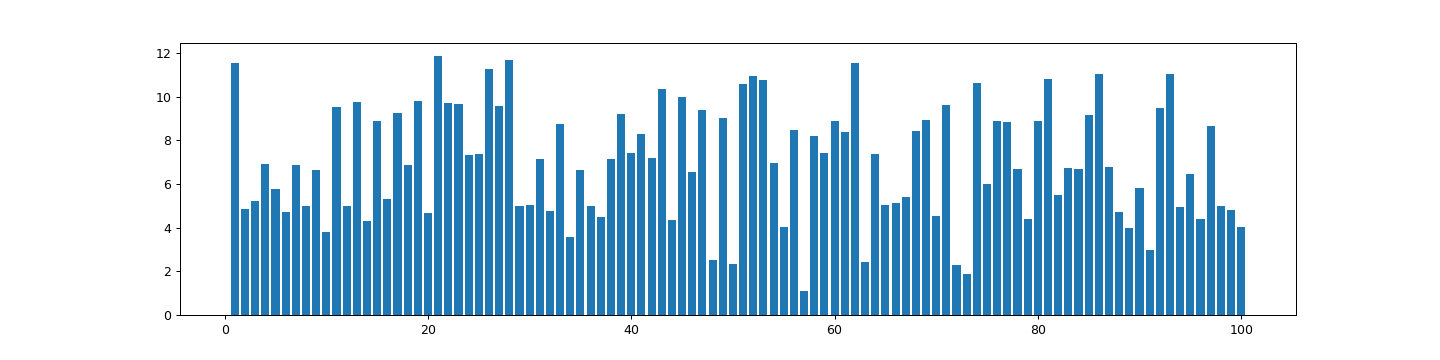

<BarContainer object of 100 artists>

In [54]:
iterations,deviations=zip(*dev_Avg_c_gravity_y_iter.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,deviations)

<IPython.core.display.Javascript object>


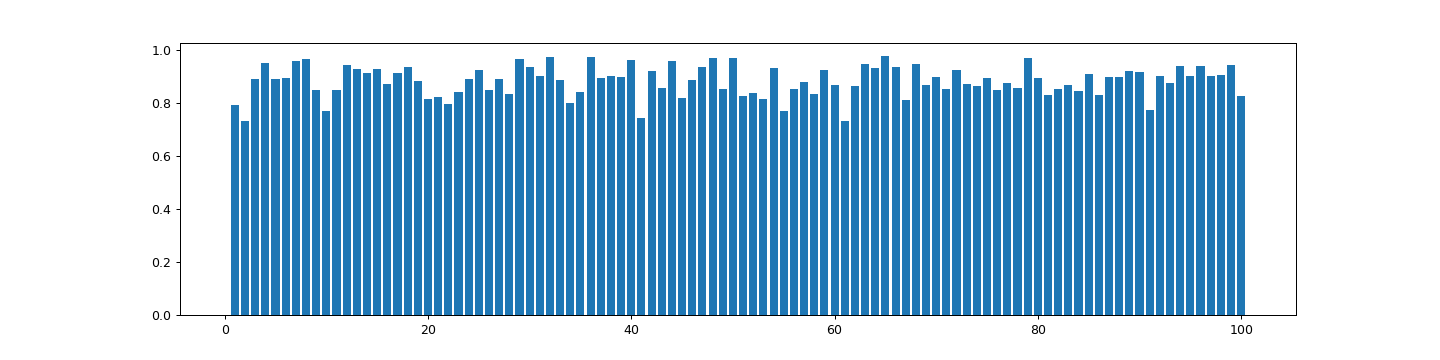

<BarContainer object of 100 artists>

In [55]:
iterations,vol_util=zip(*modified_volume_utilization.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,vol_util)

<IPython.core.display.Javascript object>


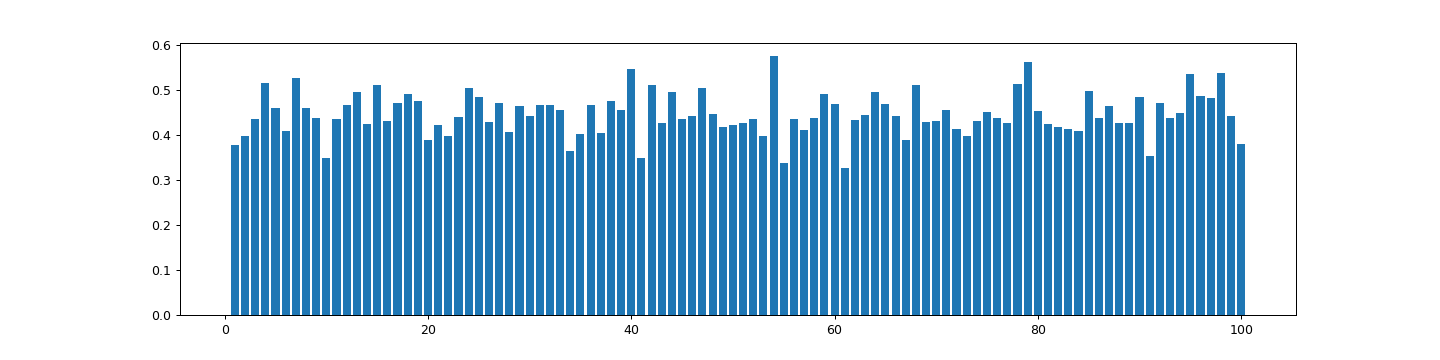

<BarContainer object of 100 artists>

In [56]:
iterations,weight_util=zip(*modified_weight_utilization.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,weight_util)

In [57]:
max(Avg_c_gravity_y_iter.values())

16.851416734728335

In [58]:
Avg_weight_utilization_iter={}
for it,bins in weight_utilization_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_weight_utilization_iter[it]=avg


In [59]:
Avg_volume_utilization_iter={}
for it,bins in volume_utilization_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_volume_utilization_iter[it]=avg

In [60]:
Avg_weight_utilization_iter

{1: 1.3306718819871255,
 2: 0.6907141297226469,
 3: 0.8872344762320741,
 4: 1.038990198525359,
 5: 0.9232918733555882,
 6: 0.7539048918977943,
 7: 1.156499727014632,
 8: 0.7765815680279538,
 9: 0.8840188047920631,
 10: 0.5302044478415957,
 11: 1.1406097271186264,
 12: 0.8581922908932081,
 13: 1.3069922108175,
 14: 0.670952609740118,
 15: 1.3003258483345292,
 16: 0.8734172906332222,
 17: 1.3150841912873472,
 18: 1.0171562620243553,
 19: 1.210332399983361,
 20: 0.6912480891024241,
 21: 1.331186295614555,
 22: 1.2154893119728782,
 23: 1.1525651915057353,
 24: 1.2333476325668944,
 25: 1.0600976403664764,
 26: 1.3457032389063945,
 27: 1.3160310761343192,
 28: 1.3656166011501785,
 29: 0.7473464366309965,
 30: 0.8443529518817792,
 31: 1.0870876023045164,
 32: 0.7562524568683118,
 33: 1.184233930261338,
 34: 0.5596660842978817,
 35: 0.8500506478852733,
 36: 0.9244871150906311,
 37: 0.628556453374099,
 38: 1.1256975894092076,
 39: 1.1474322866294366,
 40: 1.289623269792739,
 41: 0.8868243222163

In [61]:
plt.scatter(list(max_weight_utilization_iter.values()), list(max_volume_utilization_iter.values()),  markersize=16, label='Non Pareto-optimal')
#_=plt.title('The input data', fontsize=15)
plt.xlabel('Objective 1', fontsize=16)
plt.ylabel('Objective 2', fontsize=16)
#plt.show()

AttributeError: 'PathCollection' object has no property 'markersize'

In [62]:
list(max_weight_utilization_iter.values())

[0.48738589211618255,
 0.46417543859649124,
 0.4699170124481328,
 0.6579875518672199,
 0.4963070539419087,
 0.47892116182572614,
 0.6642946058091286,
 0.531140350877193,
 0.6028215767634855,
 0.43040350877192984,
 0.5035269709543568,
 0.5111618257261411,
 0.6429045643153527,
 0.4839473684210526,
 0.6932572614107884,
 0.5433402489626556,
 0.6138796680497925,
 0.6070539419087136,
 0.732551867219917,
 0.5352489626556016,
 0.6005186721991701,
 0.6230497925311204,
 0.5932365145228216,
 0.6847302904564315,
 0.5991078838174274,
 0.5646887966804979,
 0.6321161825726141,
 0.4985,
 0.4737719298245614,
 0.4824066390041494,
 0.6363070539419087,
 0.484149377593361,
 0.5870539419087137,
 0.4550877192982456,
 0.44663900414937757,
 0.4897017543859649,
 0.4493684210526316,
 0.6333609958506224,
 0.5582780082987552,
 0.6934439834024896,
 0.499356846473029,
 0.7344398340248963,
 0.5158298755186722,
 0.5800414937759336,
 0.5900207468879668,
 0.5202282157676349,
 0.6185477178423237,
 0.4556491228070175,
 0.

<IPython.core.display.Javascript object>


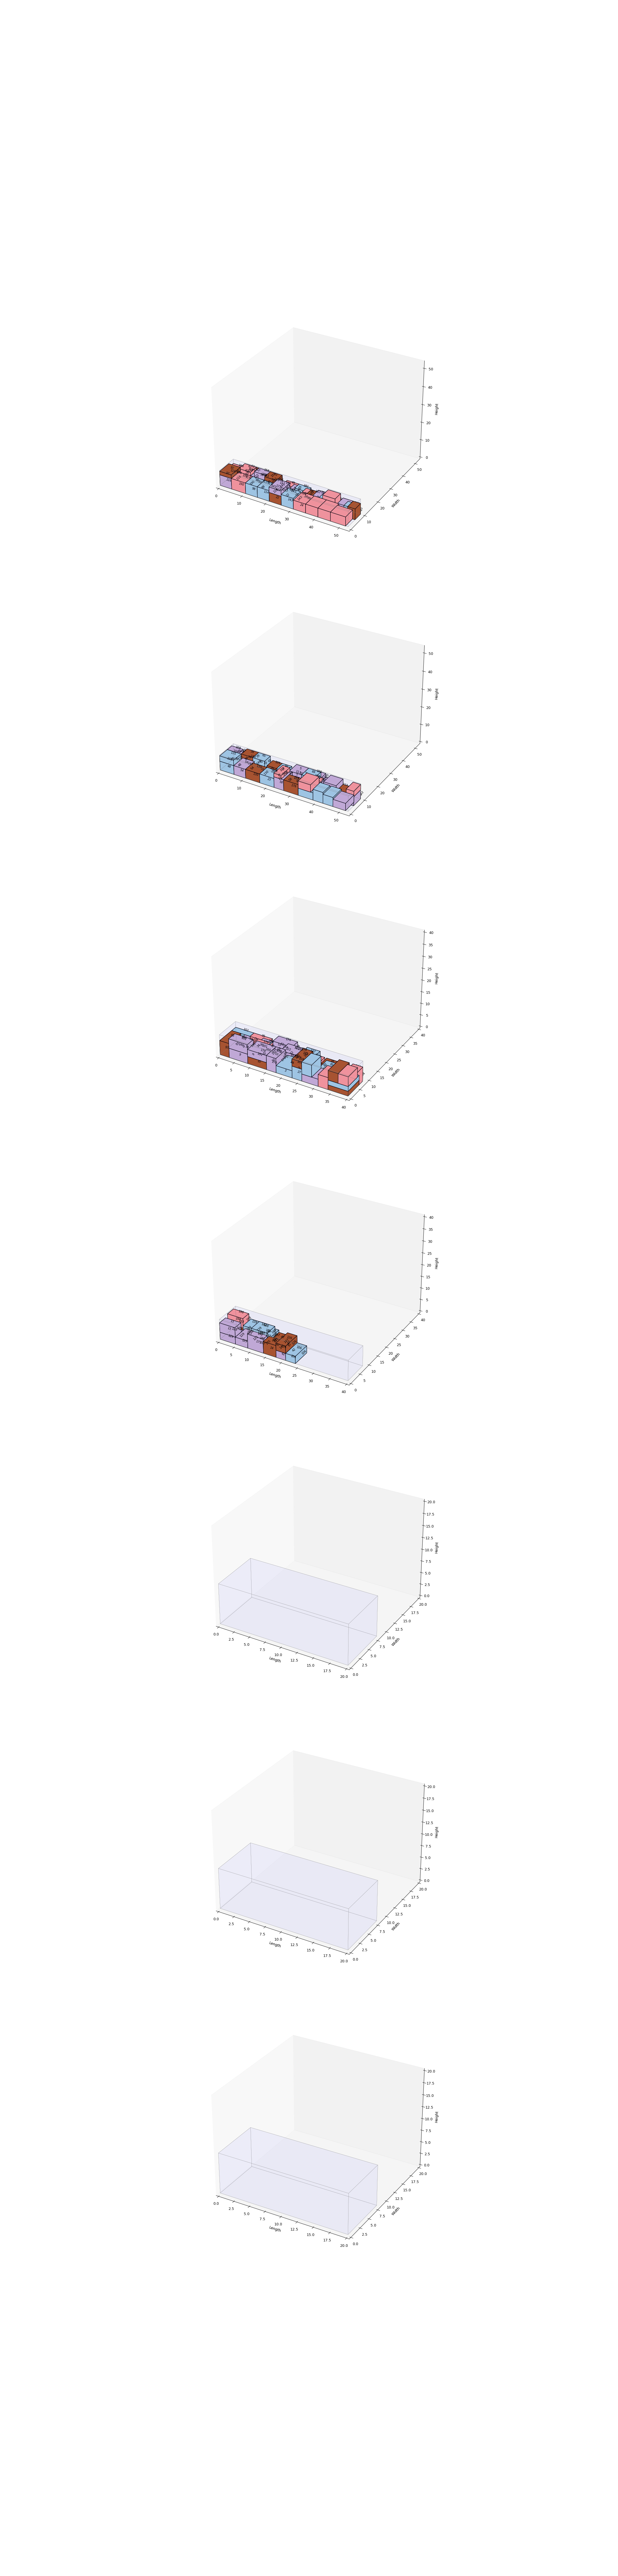

In [63]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mycolorpy import colorlist as mcp

from itertools import product
%matplotlib inline
%matplotlib nbagg
from matplotlib import cm

used_iter=max_iter_volume
flb={}
flt={}
frt={}
frb={}

rlb={}
rlt={}
rrt={}
rrb={}


nrows=len(bins)
fig = plt.figure(figsize=(24 ,100))


colors={}
classes=list(set(p_class.values()))
#size=len(set(p_class.values()))
c=mcp.gen_color(cmap="Paired",n=len(classes))
for i in range(len(classes)):
    colors[classes[i]]=c[i]
color={}
for  i,value in p_class.items():
    color[i]=colors[value]

# create list of corners
#z = list(product([-1,1], repeat=3))
for e in bins:

    x={}
    y={}
    z={}

    l={}
    w={}
    h={}


    ax = fig.add_subplot(nrows,1,e, projection='3d')
    FLB=(0,0,0)
    FLT=(0,0,H[e])
    FRT=(0,W[e],H[e])
    FRB=(0,W[e],0)

    RLB=(L[e],0,0)
    RLT=(L[e],0,H[e])
    RRT=(L[e],W[e],H[e])
    RRB=(L[e],W[e],0)

    bin_verts=[  [FLB,FLT,FRT,FRB],
             [FLB,FLT,RLT,RLB],
             [FLT,FRT,RRT,RLT],
             [RRT,FRT,FRB,RRB],
             [RLB,FLB,FRB,RRB],
             [RLB,RLT,RRT,RRB ]
             ]
    ax.set_xlim3d(0,L[e])
    ax.set_ylim3d(0,L[e])
    ax.set_zlim3d(0,L[e])
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')
    ax.set_zlabel('Height')
    ax.grid(False)
# plot sides
    ax.add_collection3d(Poly3DCollection(bin_verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.025))

    for c in p_class:
        c=mcp.gen_color(cmap="seismic",n=5)
#for e in IP_iter_update.keys():

    for i in IP_iter[used_iter][e]:
        x[i]=x_iter[used_iter][e][i]
        y[i]=y_iter[used_iter][e][i]
        z[i]=z_iter[used_iter][e][i]

        l[i]=l_iter[used_iter][e][i]
        w[i]=w_iter[used_iter][e][i]
        h[i]=h_iter[used_iter][e][i]

        flb[i]=(x[i],y[i],z[i])
        flt[i]=(x[i],y[i],z[i]+h[i])
        frt[i]=(x[i],y[i]+w[i],z[i]+h[i])
        frb[i]=(x[i],y[i]+w[i],z[i])

        rlb[i]=(x[i]+l[i],y[i],z[i])
        rlt[i]=(x[i]+l[i],y[i],z[i]+h[i])
        rrt[i]=(x[i]+l[i],y[i]+w[i],z[i]+h[i])
        rrb[i]=(x[i]+l[i],y[i]+w[i],z[i])

        box_verts=[  [flb[i],flt[i],frt[i],frb[i]],
                [flb[i],flt[i],rlt[i],rlb[i]],
                [flt[i],frt[i],rrt[i],rlt[i]],
                [rrt[i],frt[i],frb[i],rrb[i]],
                [rlb[i],flb[i],frb[i],rrb[i]],
                [rlb[i],rlt[i],rrt[i],rrb[i]]
                ]



        ax.add_collection3d(Poly3DCollection(box_verts,facecolors=color[i], linewidths=1, edgecolors='black', alpha=1))
        ax.text((x[i]+l[i]),(y[i]+w[i]/2),(z[i]+h[i]/2),   i,'y', size=8, zorder=30,color='black')
        ax.text((x[i]+l[i]/2),(y[i]),(z[i]+h[i]/2),   i,'x', size=8, zorder=30,color='black')
        ax.text((x[i]+l[i]/2),(y[i]+w[i]/2),(z[i]+h[i]),   i,'x', size=8, zorder=30
            ,
    color='black')
#'(%d, %d, %d), dir=%s' % (x, y, z, zdir)

"""
label1 = "FRONT"
label2 = "REAR"
#label3 = "BOTTOM"
ax.text(0, W/2, H/2, '%s' % (label1), size=10,zorder=7, color='black')
ax.text(L, W/2, H/2, '%s' % (label2), size=10,zorder=10, color='blue')
#ax.text(6, 2, 0, '%s' % (label3), size=20,zorder=5, color='blue')
#ax.view_init(elev=0, azim=45)
"""
plt.show()

In [82]:
plt.savefig('3-d-loading-200.png')